In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [5]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.04
rv = 3.1

# tfl = 58972.46296299994


In [6]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

distmod = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(distmod))


Luminosity distances = 114.48 Mpc
Distance modulus = 35.29


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

## SALT3 fit

In [10]:
joj_SALT = {}
lc = joj_ZTF.copy()
arg = ((lc['MJD'] - t_max_mjd) / (1 + z) <= 50) & ((lc['MJD'] - t_max_mjd) / (1 + z) >= -25)
joj_SALT['time'] = lc['MJD'][arg]
joj_SALT['band'] = lc['passband'][arg]
joj_SALT['flux'] = lc['fnu_microJy'][arg]
joj_SALT['fluxerr'] = lc['fnu_microJy_unc'][arg]
joj_SALT['zp'] = [2.5 * np.log10(3631 * 1e6)] * len(lc[arg])
joj_SALT['zpsys'] = ['ab'] * len(lc[arg])
joj_SALT = Table(joj_SALT)


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


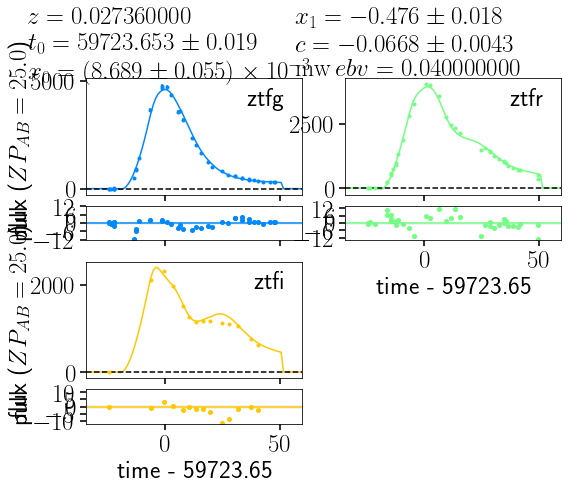

In [11]:
import sncosmo

model = sncosmo.Model(source='salt3', effects=[
                      sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])
model.set(z=z, mwebv=ebv)

result, fitted_model = sncosmo.fit_lc(
    joj_SALT, model,
    ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(joj_SALT, model=fitted_model, errors=result.errors)

In [12]:
from copy import deepcopy

peakphase_B = fitted_model.source.peakphase('bessellb')
m1 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B)
m2 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B + 15)

print('t_max_B = {:.2f}'.format(peakphase_B))
print('delta M_15 = {:.2f}'.format(m2 - m1))

t_max_B = -0.51
delta M_15 = 1.16


## Color evolution

## 1-D DDet models

In [13]:
import h5py

spec1 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
spec1 = data_binning(np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=10)
spec2 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt')
spec3 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii')

### Polin+2019

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


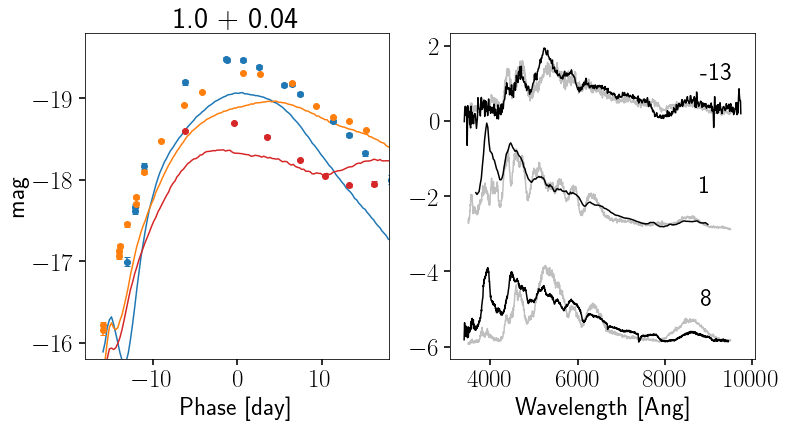

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


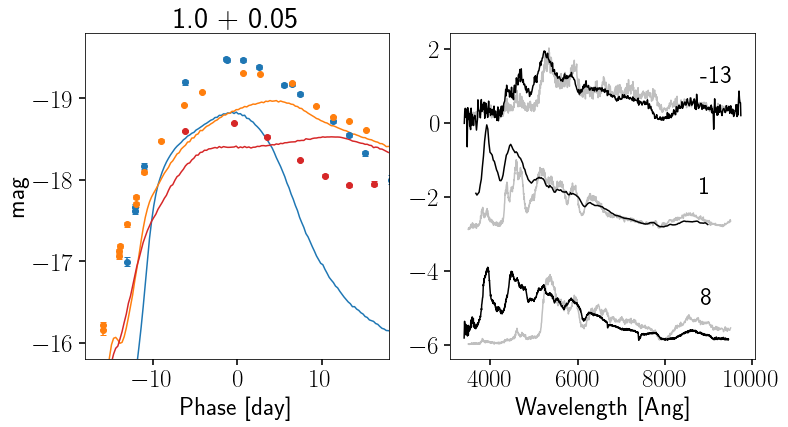

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


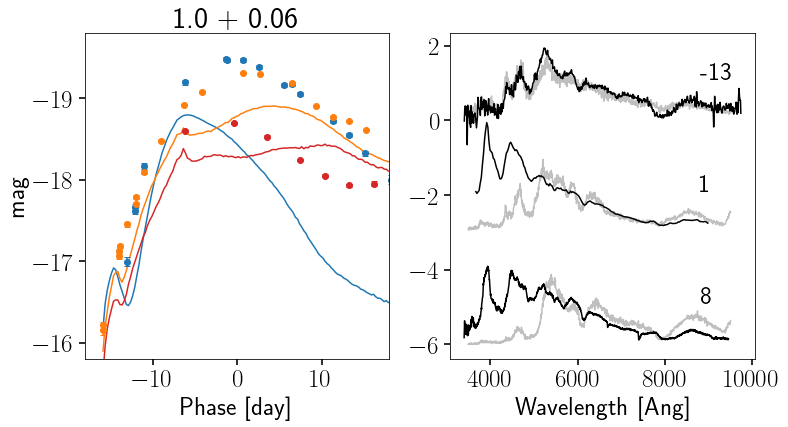

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


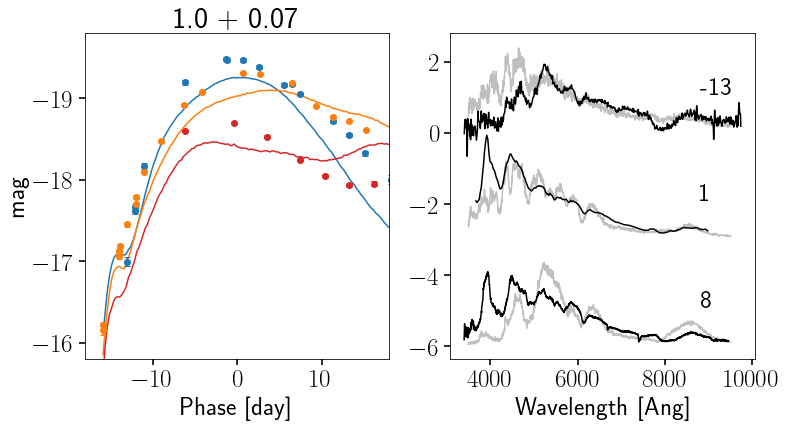

In [16]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.0*"
    )
)
filters = sorted(glob.glob("./filters/P48*"))

peakphase_r = fitted_model.source.peakphase("ztfr")
peakphase_g = fitted_model.source.peakphase("ztfg")

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) <= 0.03) or (float(ms) >= 0.08):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
    # t_max = time[ind][np.argmin(fit_g)]
    # print(t_max)
    t_max = 17

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color="tab:blue")
    ax[0].plot(time[ind] - t_max, fit_r, color="tab:orange")
    ax[0].plot(time[ind] - t_max, fit_i, color="tab:red")

    ax[0].errorbar(
        (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_g["mag"] - distmod,
        yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:blue",
    )
    ax[0].errorbar(
        (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_r["mag"] - distmod,
        yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:orange",
    )
    ax[0].errorbar(
        (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_i["mag"] - distmod,
        yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:red",
    )
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel("Phase [day]")
    ax[0].set_ylabel("mag")
    ax[0].set_title(f"{mc} + {ms}")

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.50, 2.16, 8.66]) - (peakphase_g - peakphase_B)
    specs = [spec1, spec2, spec3]
    for k in range(3):
        phase_idx = np.argmin(np.abs(time - (t_max + peakphase_r + phases[k])))
        ax[1].plot(
            wv0[idx_wv],
            Flam[phase_idx][idx_wv]
            / np.median(Flam[phase_idx][(wv0 > 5500) & (wv0 < 6500)])
            - 3 * k,
            color=".5",
            alpha=0.5,
        )
        ax[1].plot(
            specs[k][:, 0] / (1 + z),
            specs[k][:, 1]
            / np.median(
                specs[k][:, 1][
                    (specs[k][:, 0] / (1 + z) > 5500)
                    & (specs[k][:, 0] / (1 + z) < 6500)
                ]
            )
            - 3 * k,
            color="k",
        )
        ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 3 * k, color="k")
    ax[1].set_xlabel("Wavelength [Ang]")
    plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.625


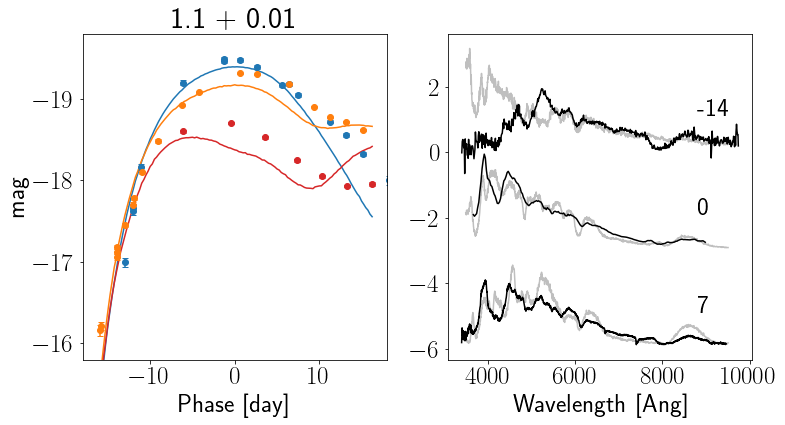

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.375


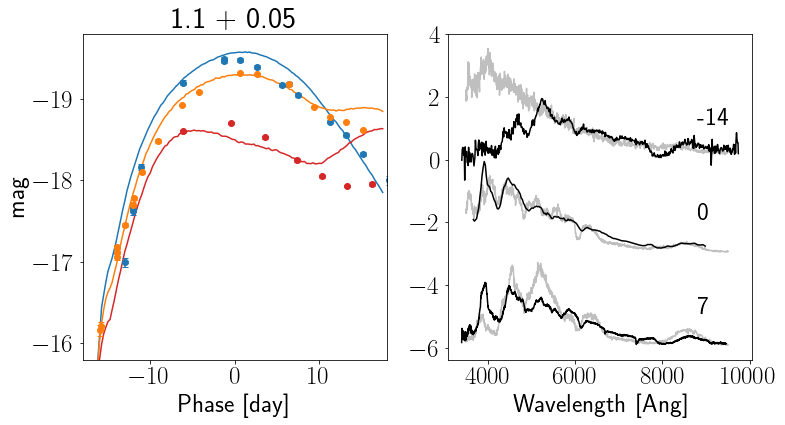

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.125


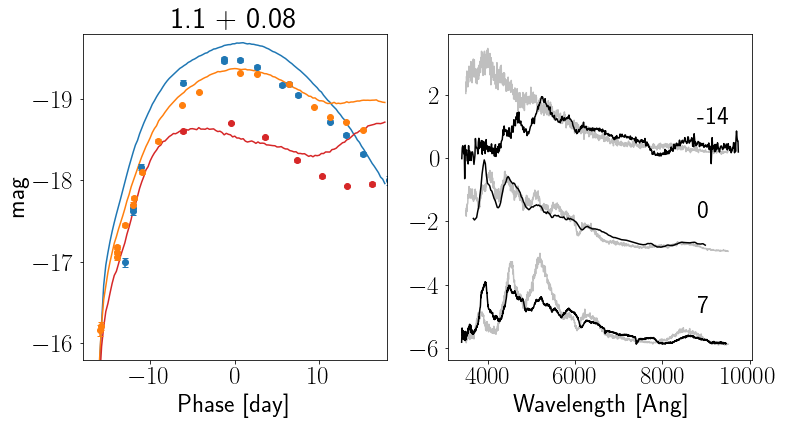

In [49]:
models = sorted(glob.glob(
    '/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.1*'))
filters = sorted(glob.glob('./filters/*P48*'))

peakphase_r = fitted_model.source.peakphase('ztfr')

for model in models:
    mod = model.split('/')[-1]
    mc, ms = mod.split('_')[-3], mod.split('_')[-2]
    if (float(ms) < 0.01) or (float(mc) + float(ms) > 1.2):
        continue
    with h5py.File(model, 'r') as f:
        Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
        time = np.array(f['time'][:] / 86400)
        nu = np.array(f['nu'][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array([(np.flip(fnu)).to(
            u.erg / u.s / u.cm**2 / u.AA,
            equivalencies=u.spectral_density(wv * u.AA))
            for fnu in Fnu]) / (1 + z)
        E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10**(-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[0]))[0]
        fit_r[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[1]))[0]
        fit_g[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[2]))[0]
    t_max = time[ind][np.argmin(fit_r)]
    print(t_max)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color='tab:blue')
    ax[0].plot(time[ind] - t_max, fit_r, color='tab:orange')
    ax[0].plot(time[ind] - t_max, fit_i, color='tab:red')
    
    ax[0].errorbar((joj_ZTF_g['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_g['mag'] -
                   distmod, yerr=[joj_ZTF_g['mag_err_l'], joj_ZTF_g['mag_err_u']], fmt='o', capsize=3, color='tab:blue')
    ax[0].errorbar((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_r['mag'] -
                   distmod, yerr=[joj_ZTF_r['mag_err_l'], joj_ZTF_r['mag_err_u']], fmt='o', capsize=3, color='tab:orange')
    ax[0].errorbar((joj_ZTF_i['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_i['mag'] -
                   distmod, yerr=[joj_ZTF_i['mag_err_l'], joj_ZTF_i['mag_err_u']], fmt='o', capsize=3, color='tab:red')
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel('Phase [day]')
    ax[0].set_ylabel('mag')
    ax[0].set_title(f'{mc} + {ms}')

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.50, 2.16, 8.66]) - (peakphase_r - peakphase_B)
    specs = [spec1, spec2, spec3]
    for k in range(3):
        phase_idx = np.argmin(np.abs(time - (t_max + peakphase_r + phases[k])))
        ax[1].plot(wv0[idx_wv], Flam[phase_idx][idx_wv] / np.median(Flam[phase_idx]
                [(wv0 > 5500) & (wv0 < 6500)]) - 3 * k, color='.5', alpha=.5)
        ax[1].plot(specs[k][:, 0]/(1+z), specs[k][:, 1] / np.median(specs[k][:, 1]
                [(specs[k][:, 0]/(1+z) > 5500) & (specs[k][:, 0]/(1+z) < 6500)]) - 3 * k, color='k')
        ax[1].text(s='{:.0f}'.format(phases[k]), x=8800, y=1.1 - 3 * k, color='k')
    ax[1].set_xlabel('Wavelength [Ang]')
    plt.show()


In [78]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.1*"
    )
)
filters = sorted(glob.glob("./filters/*P48*"))

peakphase_r = fitted_model.source.peakphase("ztfr")

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.01) or (float(mc) + float(ms) > 1.2):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)],
            flt=np.loadtxt("./filters/Bessell_B.dat"),
        )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    np.savetxt(
        f"./Polin+19_model/mc_{mc}_ms_{ms}_lc.txt",
        np.array([time[ind], fit_g, fit_r, fit_i, fit_B]).T,
        fmt="%.2f %.3f %.3f %.3f %.3f",
        header="Time ZTFg ZTFr ZTFi B",
    )

    idx_wv = (wv0 > 3000) & (wv0 < 9500)
    phases = np.array([-1, 0, 1, 2, 3, 4])
    for k in range(len(phases)):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        np.savetxt(
            f"./Polin+19_model/mc_{mc}_ms_{ms}_phase_{phases[k]}_spec.txt",
            np.array(
                [
                    wv,
                    Flam[phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

17.875
16.875
16.375


In [20]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.*"
    )
)
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) <= 0.02) or (float(ms) >= 0.06):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)],
            flt=np.loadtxt("./filters/Bessell_B.dat"),
        )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)

    idx_wv = (wv0 > 3000) & (wv0 < 10000)
    phases = np.array([-13, -12, -11, 0, 2])
    for k in range(len(phases)):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        np.savetxt(
            f"./Polin+19_model/mc_{mc}_ms_{ms}_phase_{phases[k]}_spec.txt",
            np.array(
                [
                    wv,
                    Flam[phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.625
15.875
14.875
16.875
15.625


### Shen+2021

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


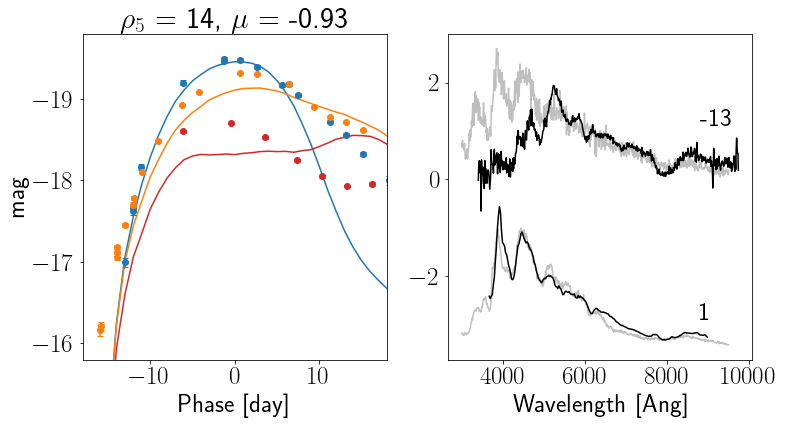

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


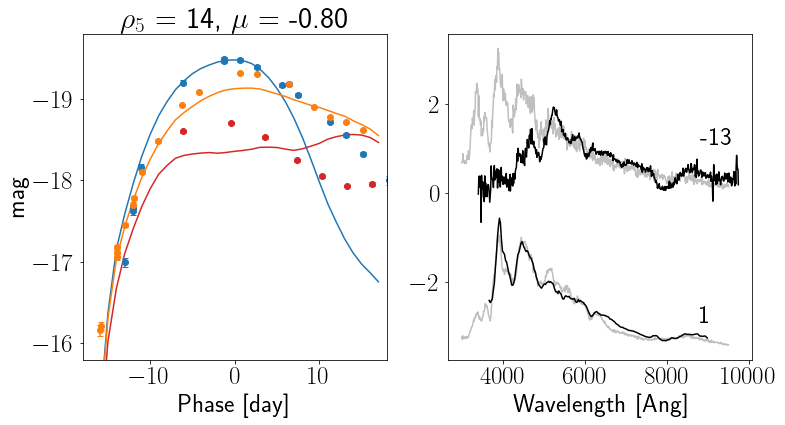

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


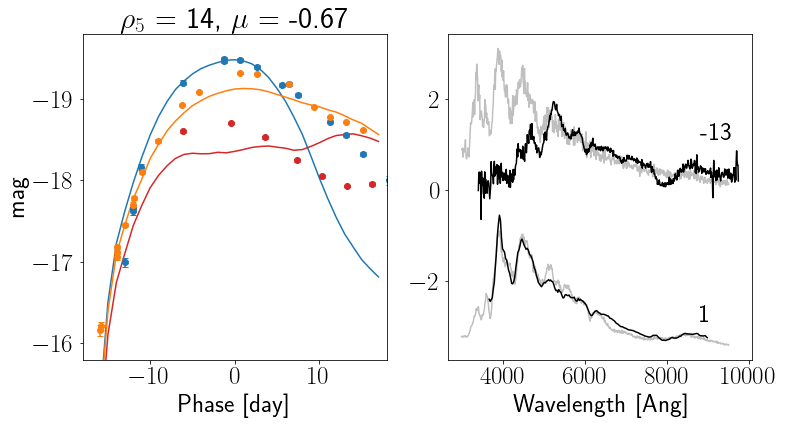

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


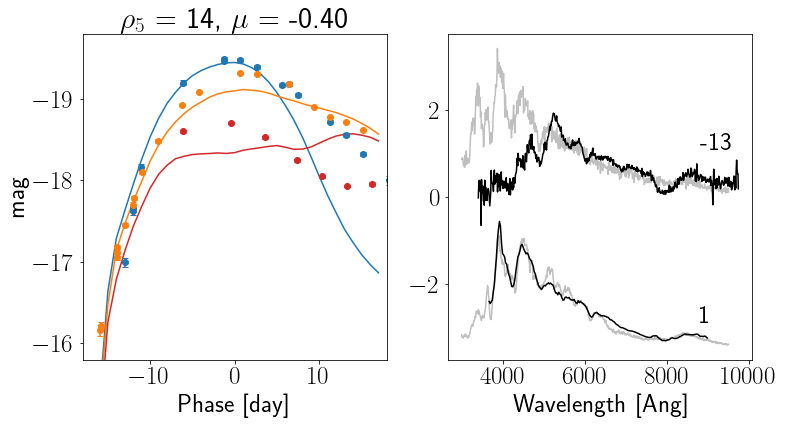

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


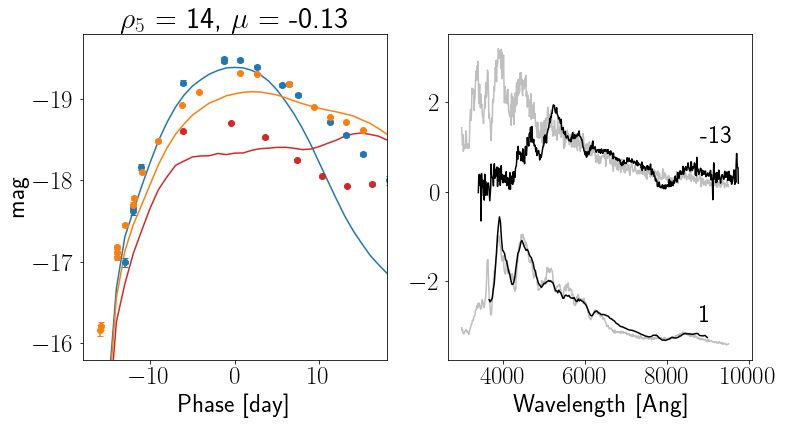

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


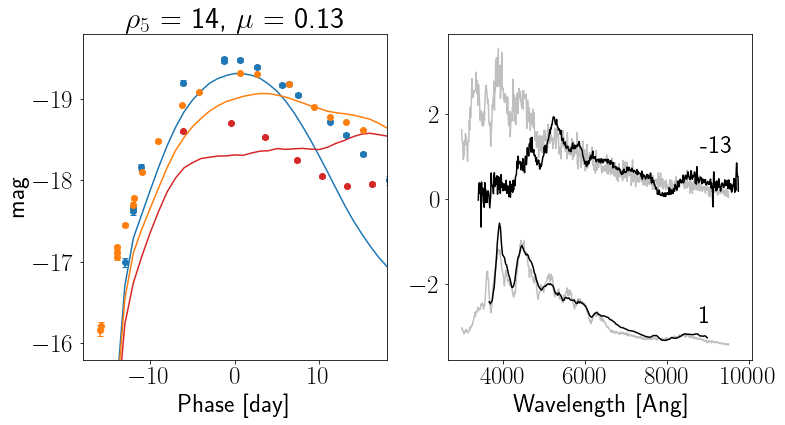

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


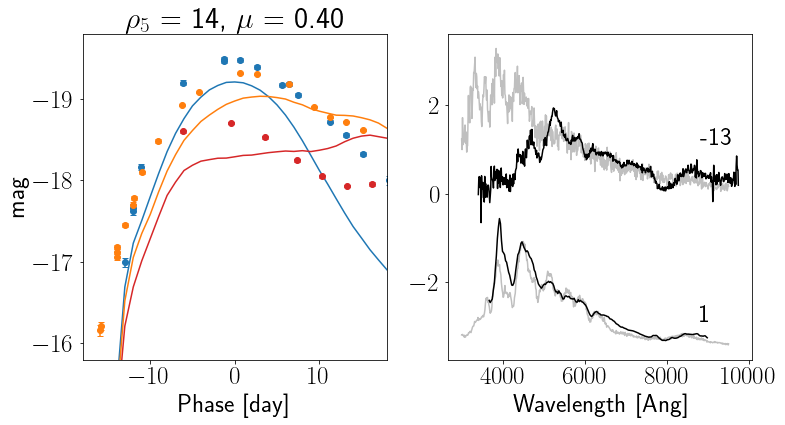

In [50]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_??e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

peakphase_g = fitted_model.source.peakphase("ztfg")

for model in models:

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [0, 1, 2, 4, 6, 8, 10]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
        t_max = time[ind][::2][np.argmin(fit_g)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.50, 2.16]) - (peakphase_g - peakphase_B)
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_g + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            # if phases[k] > 0:
            #     log_Lsun = np.log10(
            #         trapz(
            #             (Flam[i][phase_idx] / (E_Gal * E_Host))[idx_wv],
            #             wv0[idx_wv],
            #         )
            #         * (4 * np.pi * (10 * u.pc).to("cm").value ** 2)
            #         * (1 + z)
            #         / 3.828e33  # Lsun in cgs
            #     )
            #     np.savetxt(
            #         "../TARDIS/Shen+2021/d{}e5_mu_{:.0f}_spec.txt".format(
            #             rho, cos_theta[i] * 100
            #         ),
            #         np.array(
            #             [
            #                 wv0,
            #                 Flam[i][phase_idx]
            #                 / (E_Gal * E_Host)
            #                 * (1 + z)
            #                 * (10e-6 / 114.48) ** 2,  # 10 pc --> D_L Mpc
            #             ]
            #         ).T[idx_wv, :],
            #         fmt="%.4f %.4e",
            #         header="time_explosion = {}\n".format(time[phase_idx])
            #         + "log_Lsun = {:.2f}".format(log_Lsun),
            #     )

            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


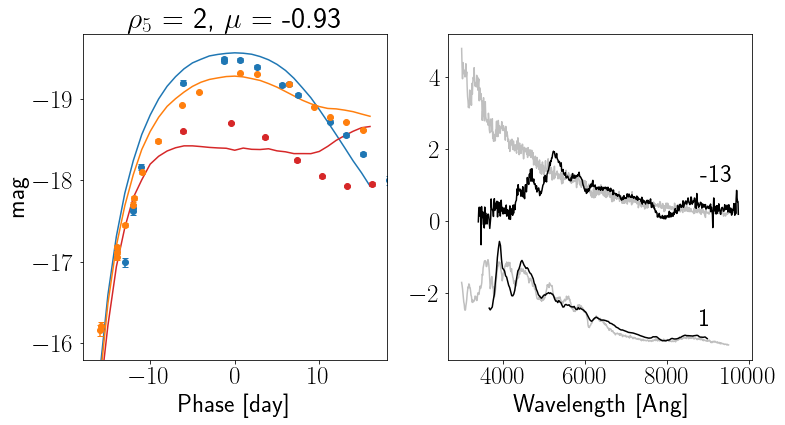

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


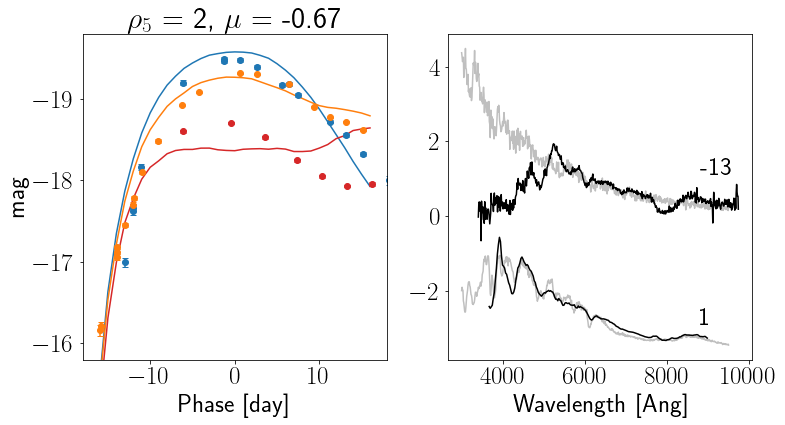

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


19.25


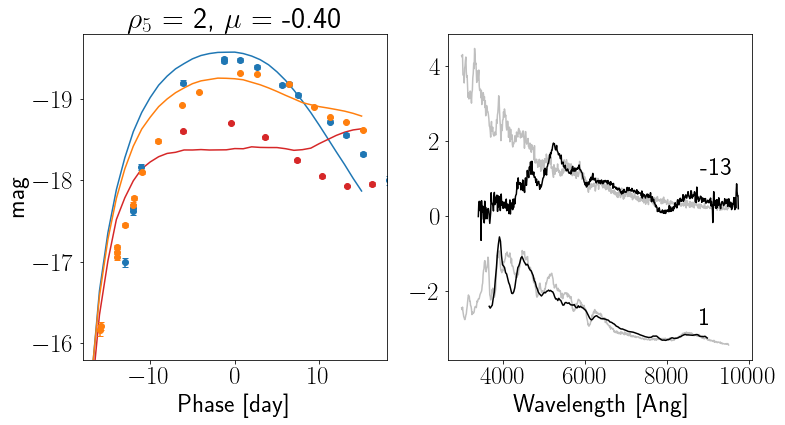

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


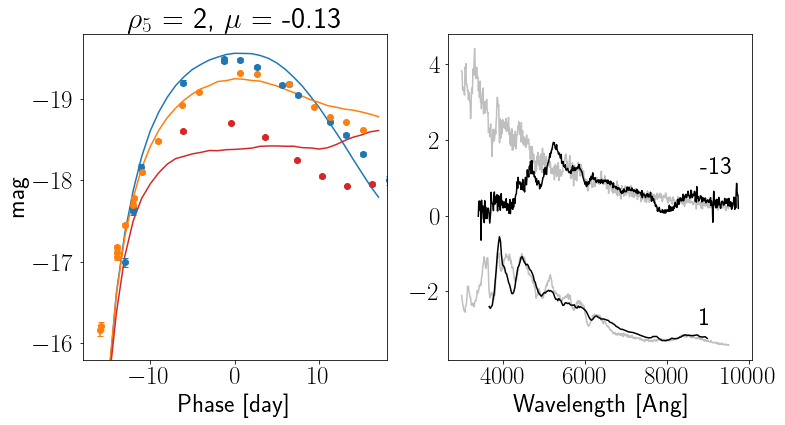

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


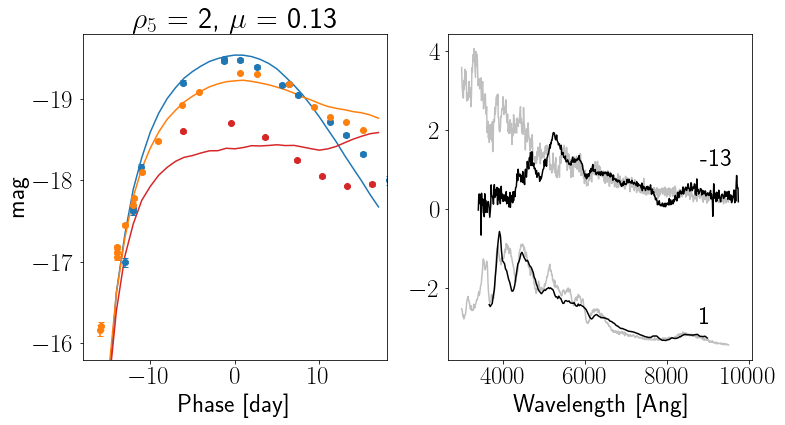

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


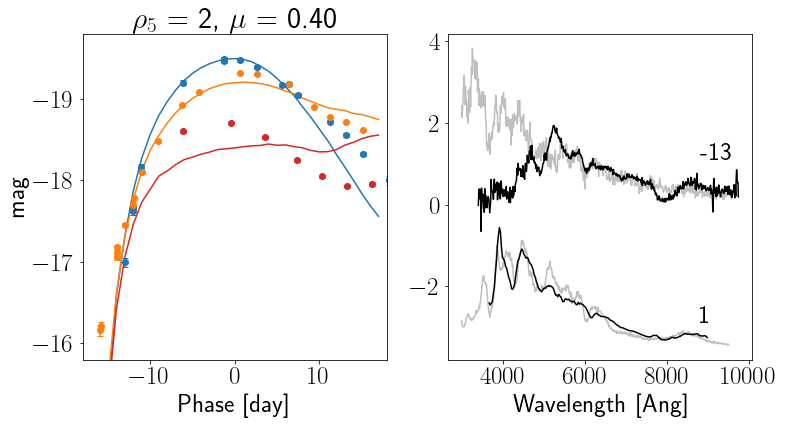

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


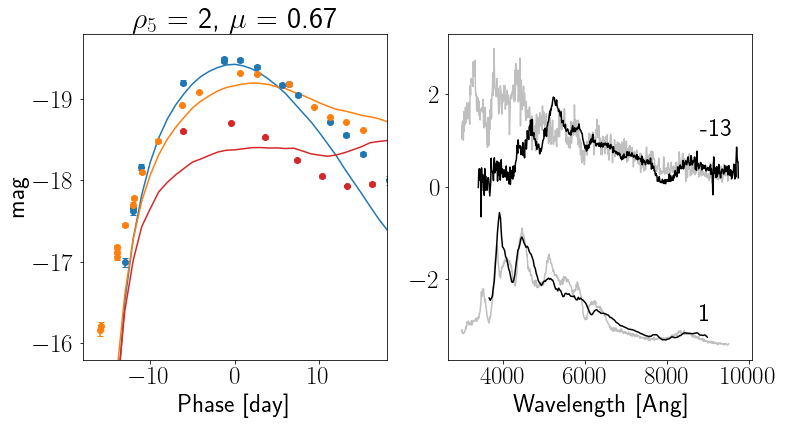

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.25


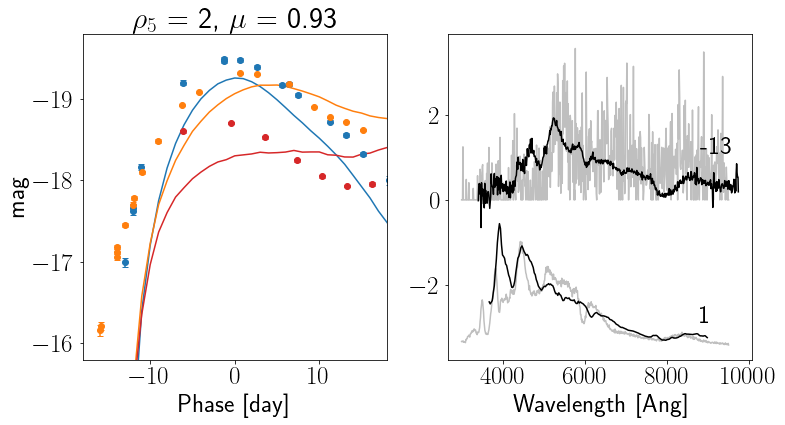

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


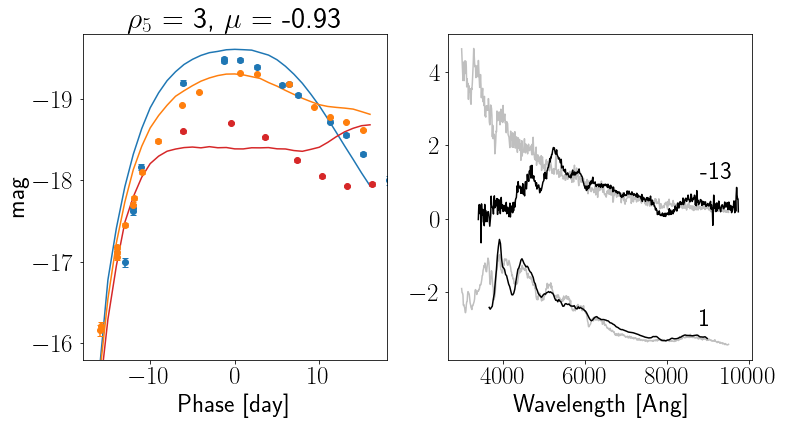

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


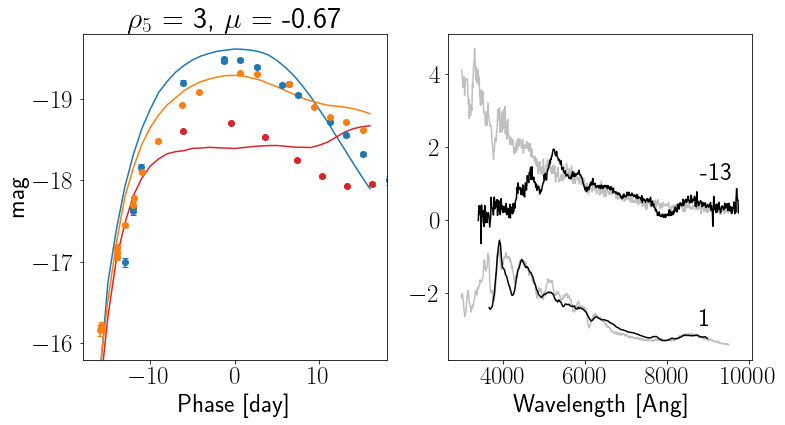

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


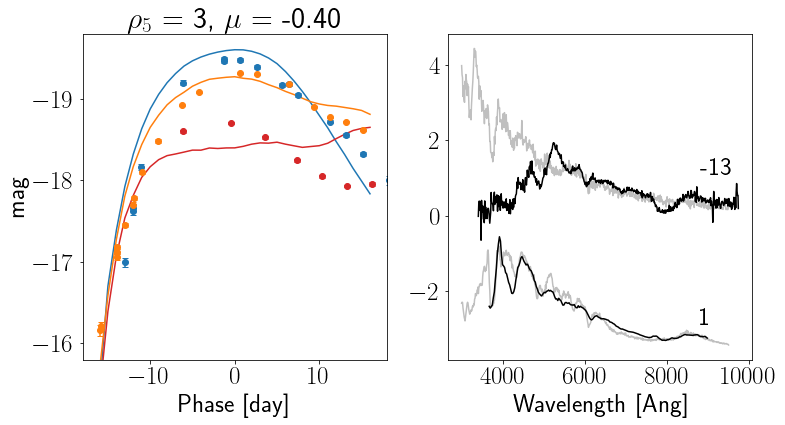

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


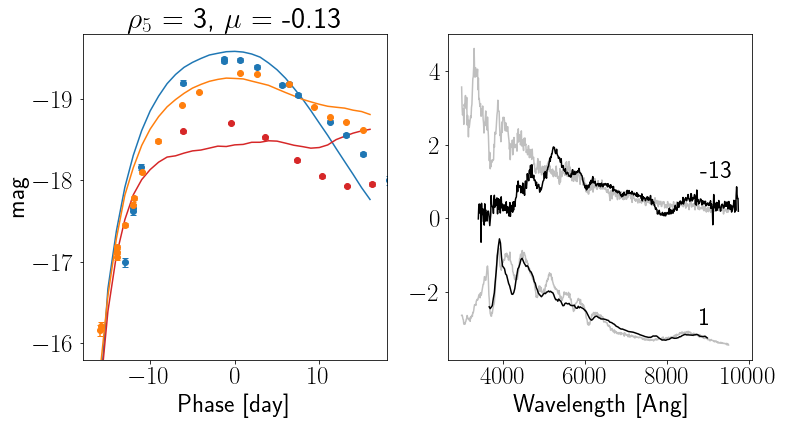

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


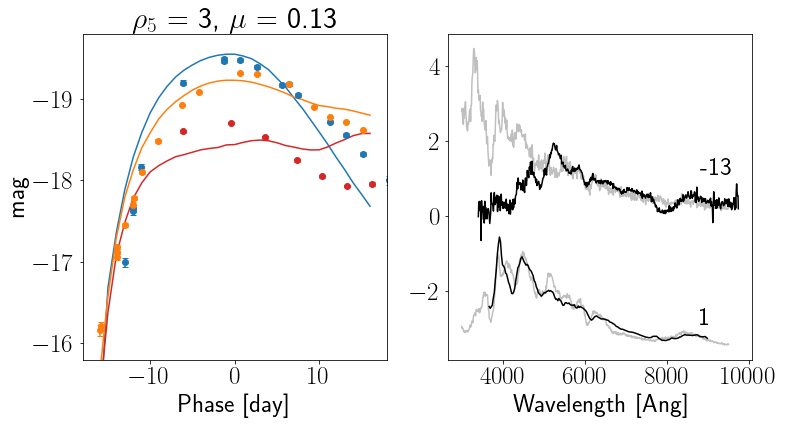

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


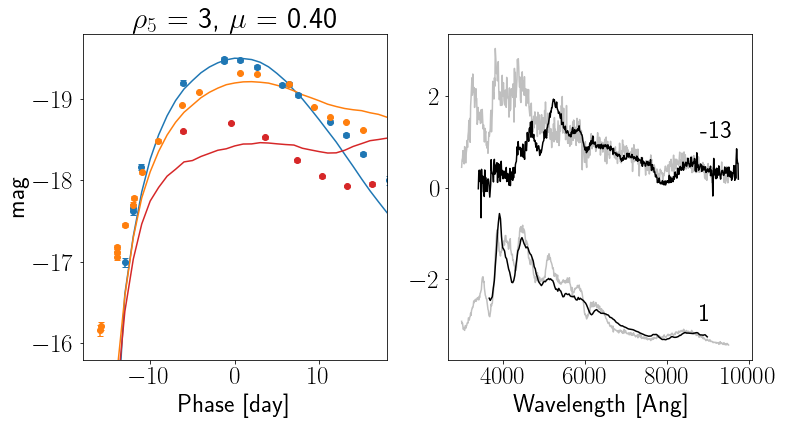

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


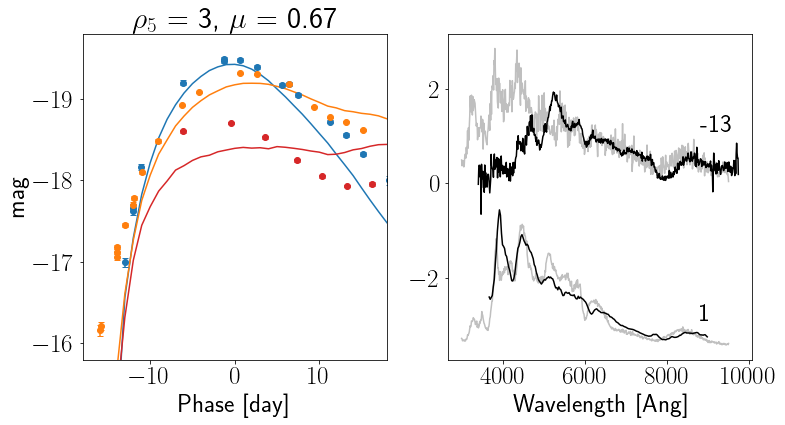

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.25


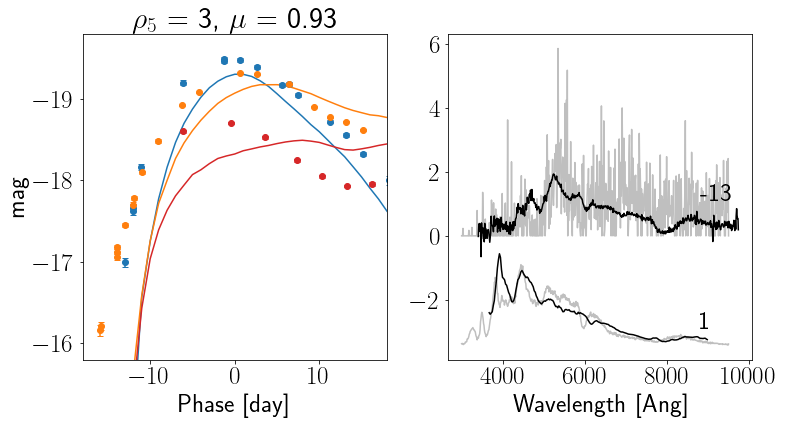

In [43]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.10_*e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

peakphase_g = fitted_model.source.peakphase("ztfg")

for model in models:

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            for i in np.arange(len(cos_theta))
        ]
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [0, 2, 4, 6, 8, 10, 12, 14]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
        t_max = time[ind][::2][np.argmin(fit_g)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.50, 2.16]) - (peakphase_g - peakphase_B)
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_g + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )

            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


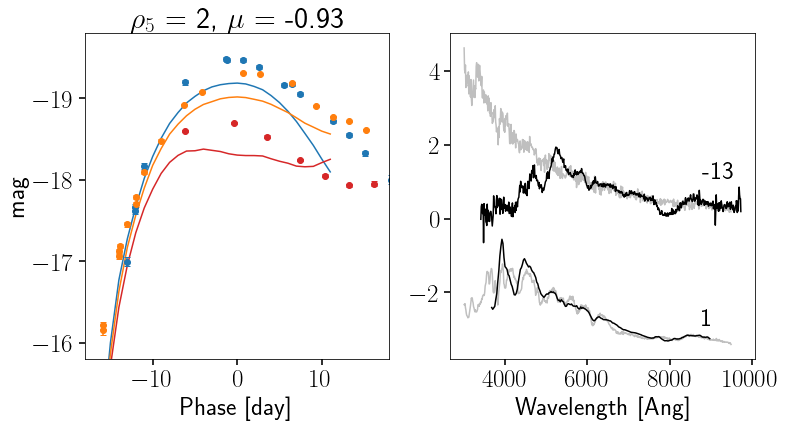

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


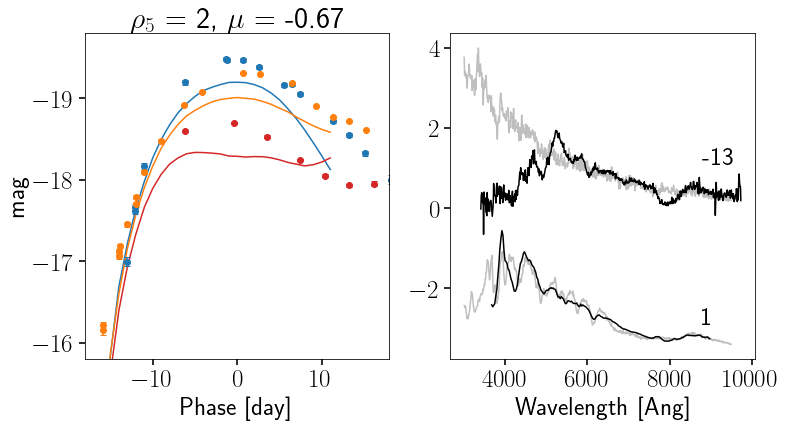

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


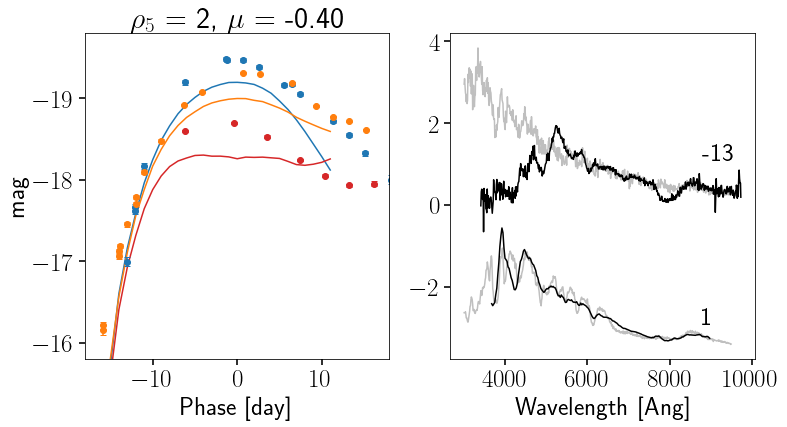

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


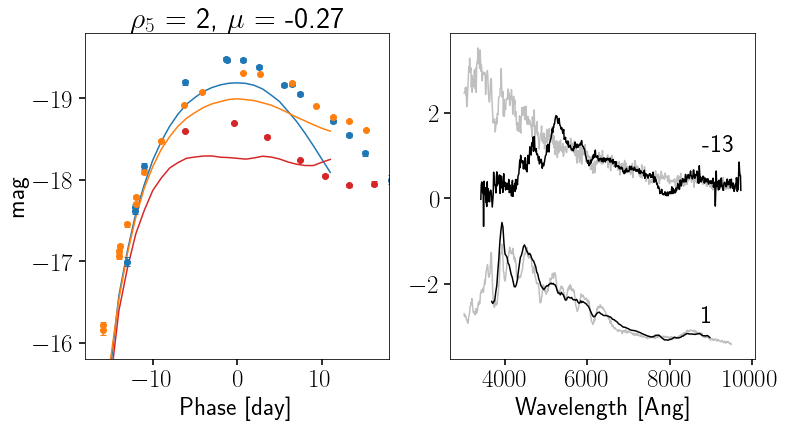

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


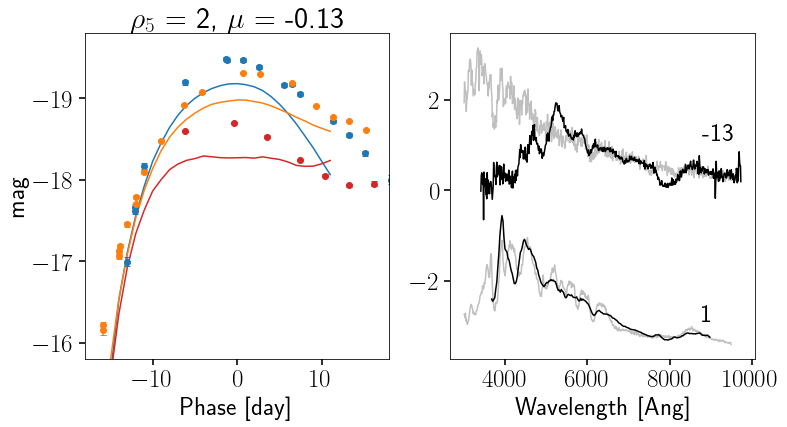

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


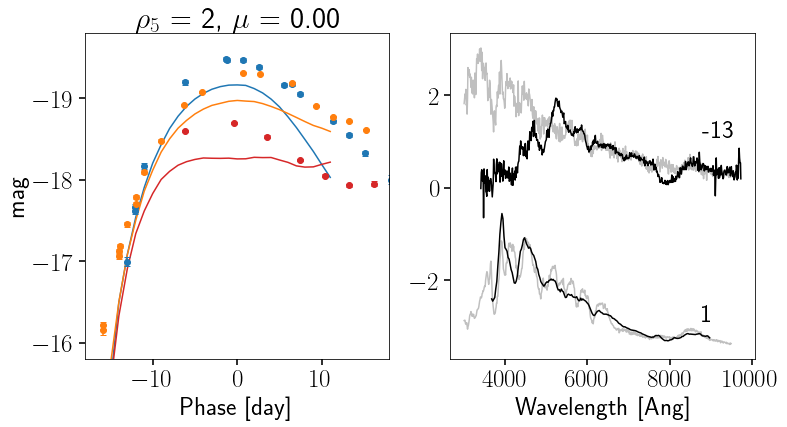

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


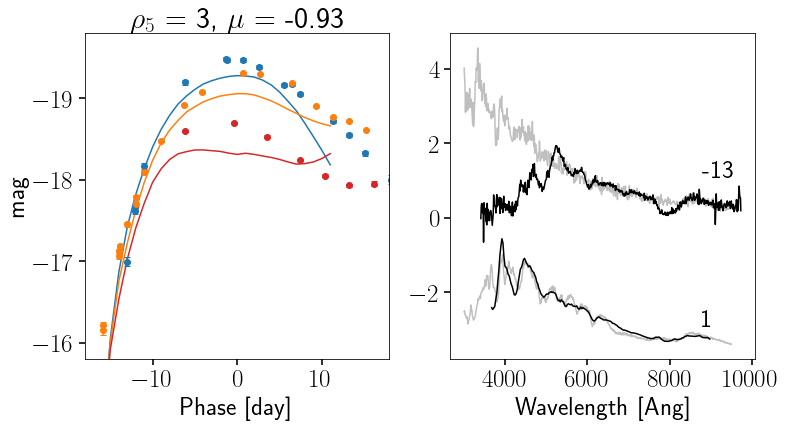

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


19.25


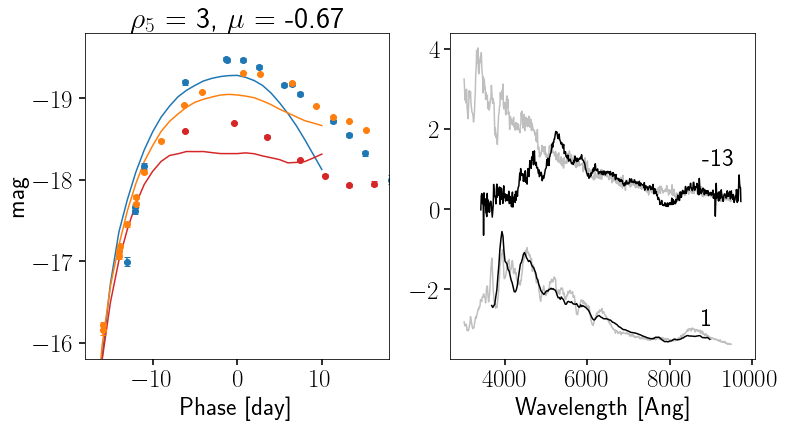

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


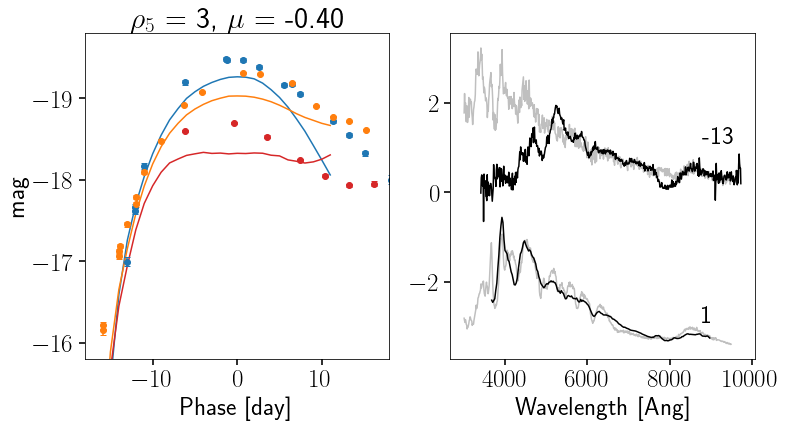

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


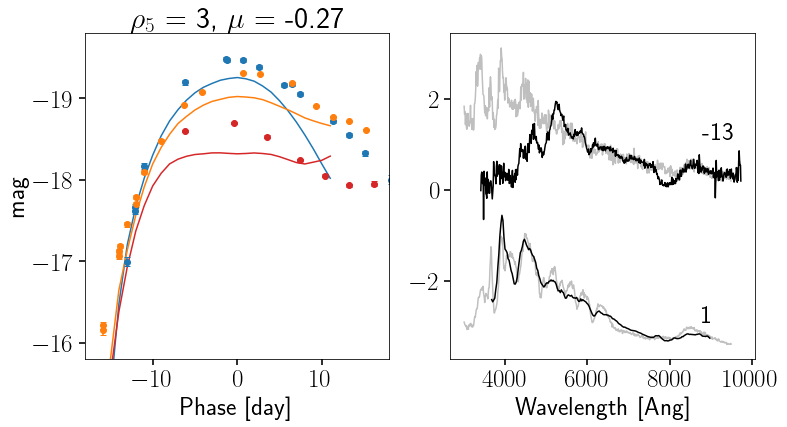

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


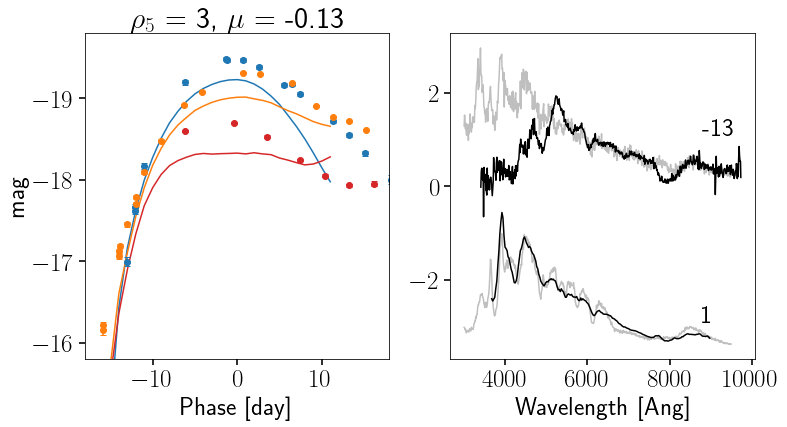

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


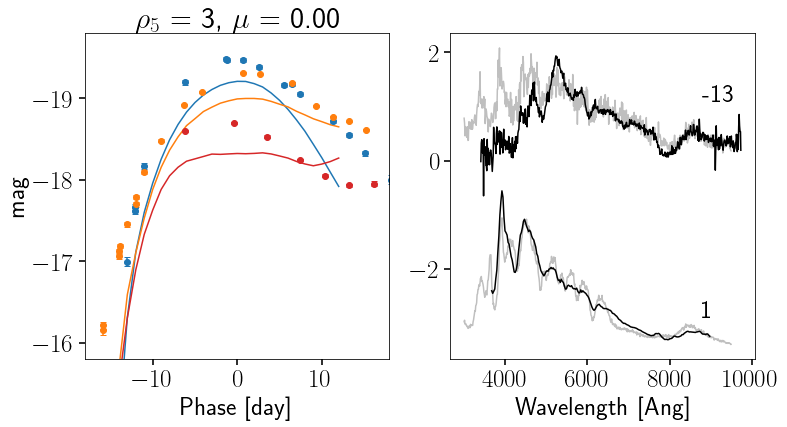

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


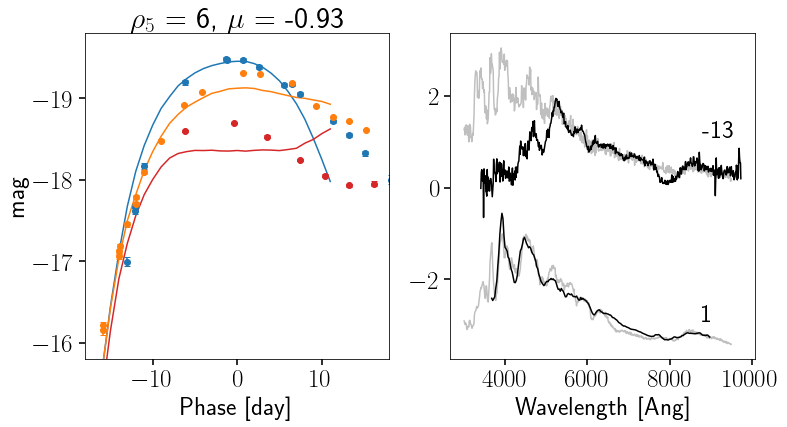

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


18.25


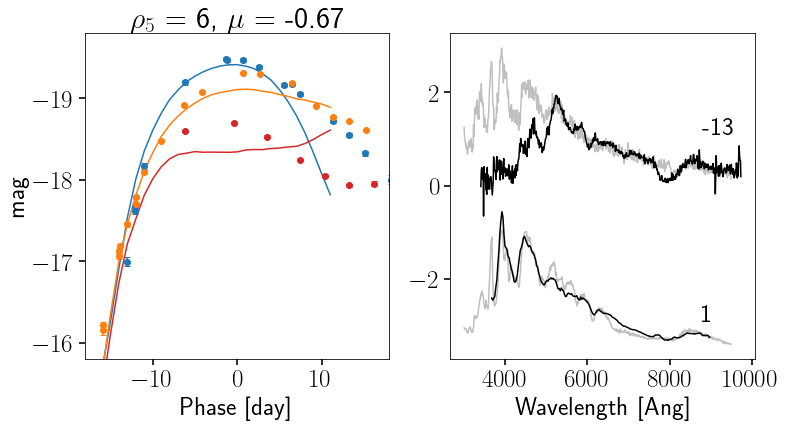

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


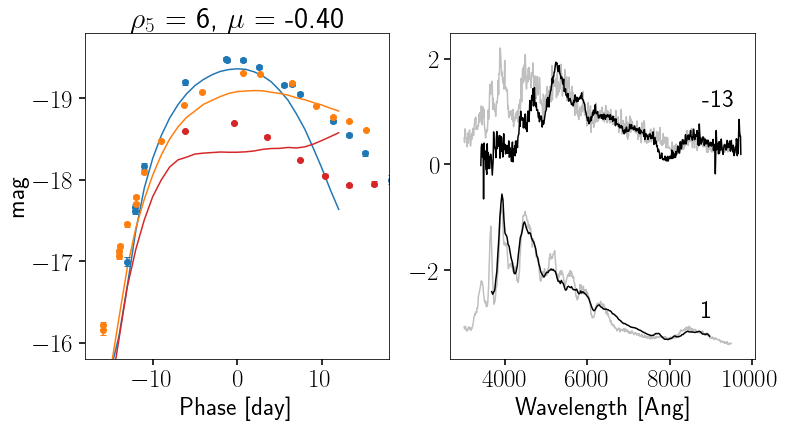

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


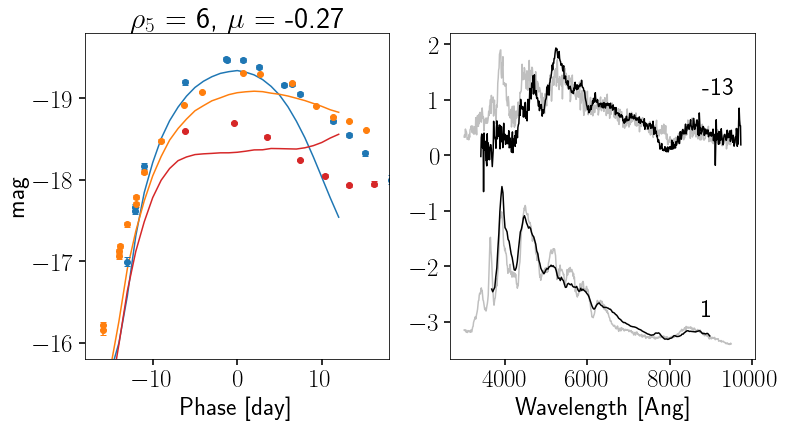

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


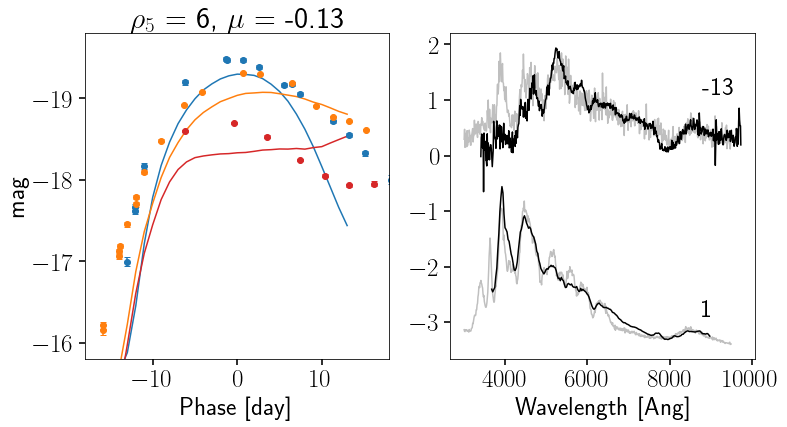

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


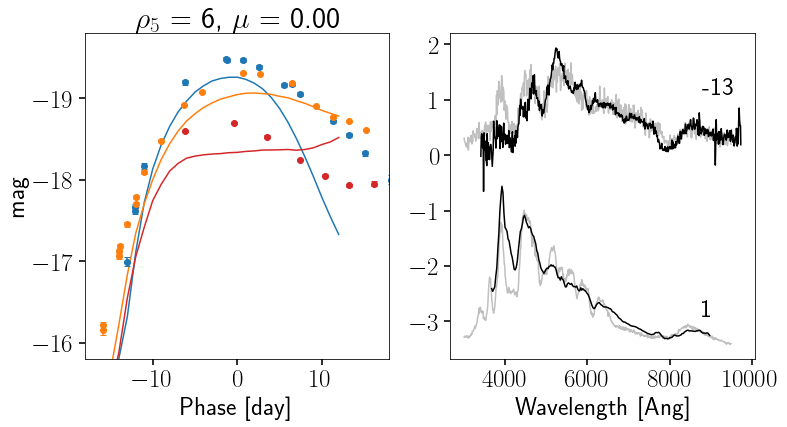

In [52]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_?e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

peakphase_g = fitted_model.source.peakphase("ztfg")

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            for i in np.arange(len(cos_theta))
        ]
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 30)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [0, 2, 4, 5, 6, 7]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
        t_max = time[ind][::2][np.argmin(fit_g)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.50, 2.16]) - (peakphase_g - peakphase_B)
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_g + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )

            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [206]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    # if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
    #     continue
    if (m_tot != 1.0) or (rho != 6): continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    for i in [0, 2, 4, 6, 8, 10, 12, 14]:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        np.savetxt(
            "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_lc.txt".format(m_tot, rho, cos_theta[i] * 100),
            np.array([time[ind], fit_g, fit_r, fit_i, fit_B, fit_B_0]).T,
            fmt="%.2f %.3f %.3f %.3f %.3f %.3f",
            header="Time ZTFg ZTFr ZTFi B B(unreddened)",
        )
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        from scipy.integrate import trapz

        phase_idx = np.argmin(np.abs(time - t_max))
        idx_wv = (wv0 > 3000) & (wv0 < 10000)
        np.savetxt(
            "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_spec.txt".format(
                m_tot, rho, cos_theta[i] * 100
            ),
            np.array(
                [
                    wv,
                    Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

1.0 6.0
16.75
16.75
16.25
15.25
14.75
14.25
13.75
12.75


In [56]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 11) & (time < 23)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    if m_tot == 1 and rho == '6':
        i_range = [3, 4, 5, 6, 7]
    else:
        i_range = [0, 2, 4]
    for i in i_range:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        phases = [-13, -12, -11, 0, 1, 2, 3]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 10000)

            np.savetxt(
                "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_phase_{:.0f}_spec.txt".format(
                    m_tot, rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv,
                        Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx]),
            )

1.0 14.0
1.0 6.0


/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.75
16.25
15.75
15.25
14.75
1.1 3.0


## Modeling the silicon features

In [207]:
sys.path.append('../spectroscopy')

from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736 #redshift
synth_spec = [f for f in sorted(glob.glob('./Shen+21_model/*mu*spec*')) if not 'phase' in f]
synth_lc = sorted(glob.glob('./Shen+21_model/*mu*lc*'))

def lambda_rf(lambda_0, vel):
    c = 2.99792458e5
    beta = vel / c
    lambda_rf = np.sqrt((1 + beta) / (1 - beta)) * lambda_0
    return lambda_rf

-13.0
LS estimation:
Velocity 1: -10604 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10717.806  238.847 -10942.460 -10478.063      4.337    3.067   
v_sig[0]    2588.554  262.260   2294.988   2804.640      6.039    4.274   
A[0]        -774.347   83.574   -844.020   -680.587      2.028    1.449   
sigma_0        0.007    0.005      0.000      0.009      0.000    0.000   
EW_0          36.926    3.714     32.463     39.747      0.088    0.063   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3049.405  2832.779  1.002  
v_sig[0]   1894.310  2677.906  1.003  
A[0]       1728.513  1968.268  1.002  
sigma_0    2377.896  1352.049  1.000  
EW_0       1785.428  2053.707  1.002  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11103.438  297.804 -11399.765 -10816.553      5.089    3.599   
v_sig[0]    2384.295  264.027   2189.295   2758.795      5.415    3.840   
A[0]        -485.211   78.907   -552.027   -395.961      1.755    1.241   
sigma_0        0.013    0.009      0.000      0.016      0.000    0.000   
EW_0          16.386    2.549     13.627     18.686      0.056    0.040   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3424.846  2749.376  1.002  
v_sig[0]   2252.655  2132.294  1.002  
A[0]       2024.809  2605.363  1.002  
sigma_0    1956.661  1283.179  1.000  
EW_0       2051.123  2692.583  1.001  


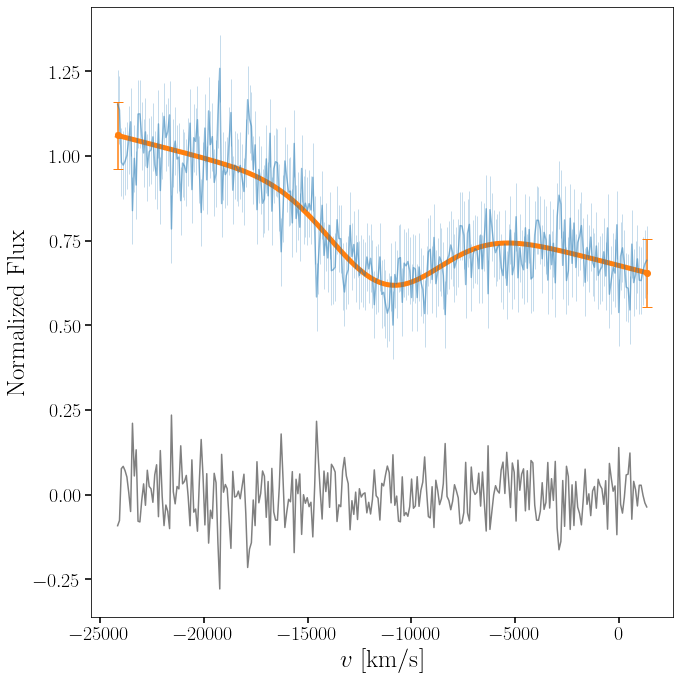

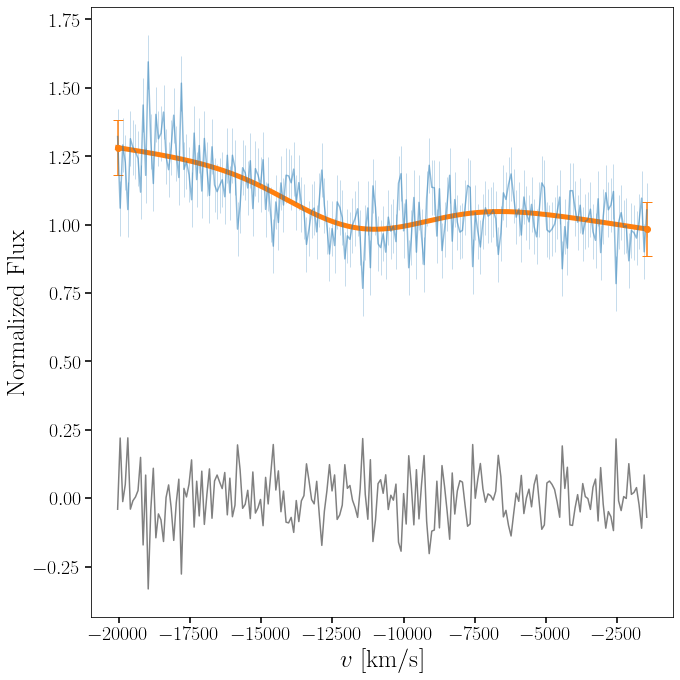

-40.0
LS estimation:
Velocity 1: -10585 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10724.142  254.602 -10966.336 -10467.590      4.108    2.905   
v_sig[0]    2612.258  286.015   2338.429   2903.171      6.037    4.285   
A[0]        -717.995   82.744   -795.791   -628.892      1.883    1.331   
sigma_0        0.006    0.005      0.000      0.008      0.000    0.000   
EW_0          35.554    3.832     31.418     39.151      0.086    0.061   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3843.780  2639.539  1.002  
v_sig[0]   2240.545  2416.031  1.000  
A[0]       1911.602  2424.964  1.002  
sigma_0    1788.624  1254.942  1.001  
EW_0       1960.022  2408.087  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11031.038  411.726 -11415.677 -10611.071      7.235    5.122   
v_sig[0]    2555.550  227.946   2475.865   2843.056      4.101    2.900   
A[0]        -353.807   76.645   -430.572   -276.238      1.617    1.143   
sigma_0        0.009    0.007      0.000      0.011      0.000    0.000   
EW_0          12.529    2.625      9.865     15.144      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3231.229  2835.496  1.001  
v_sig[0]   3191.005  2334.815  1.000  
A[0]       2236.231  2524.836  1.002  
sigma_0    1999.127  1150.944  1.001  
EW_0       2252.873  2563.164  1.002  


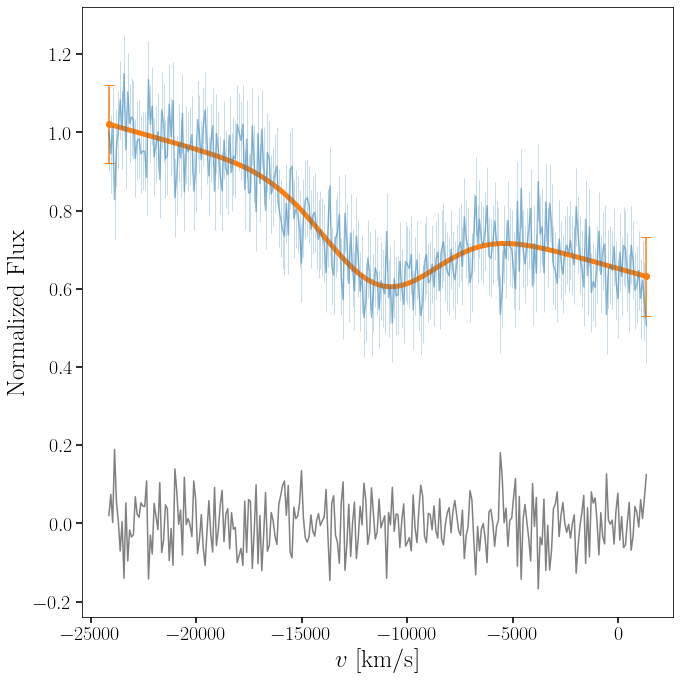

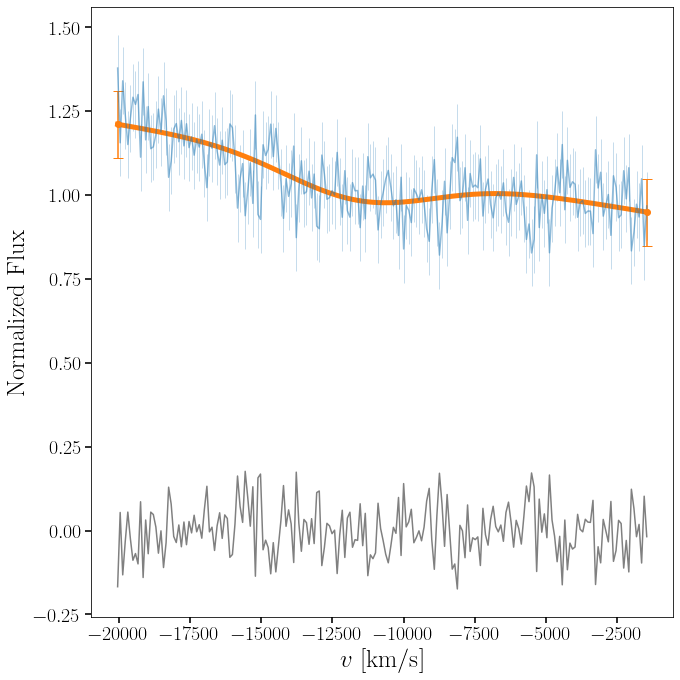

-67.0
LS estimation:
Velocity 1: -10670 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10740.174  290.793 -11074.111 -10495.622      5.184    3.666   
v_sig[0]    2549.084  356.730   2177.484   2871.094      7.789    5.514   
A[0]        -611.524   85.559   -680.970   -517.126      2.116    1.496   
sigma_0        0.006    0.005      0.000      0.008      0.000    0.000   
EW_0          30.709    4.048     26.264     33.996      0.099    0.070   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3170.211  2525.777  1.001  
v_sig[0]   2109.259  2493.784  1.001  
A[0]       1649.758  2236.718  1.002  
sigma_0    2091.342  1134.572  1.001  
EW_0       1683.741  2233.230  1.002  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11578.689  401.842 -11976.828 -11177.996      8.505    6.015   
v_sig[0]    2466.687  227.722   2383.848   2762.319      4.522    3.245   
A[0]        -346.926   76.711   -413.974   -261.473      1.754    1.240   
sigma_0        0.010    0.007      0.000      0.012      0.000    0.000   
EW_0          12.268    2.625      9.262     14.490      0.060    0.042   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2237.997  2475.531  1.000  
v_sig[0]   2296.966  1941.600  1.000  
A[0]       1887.440  2202.331  1.001  
sigma_0    2173.200  1188.942  1.000  
EW_0       1898.907  2016.115  1.001  


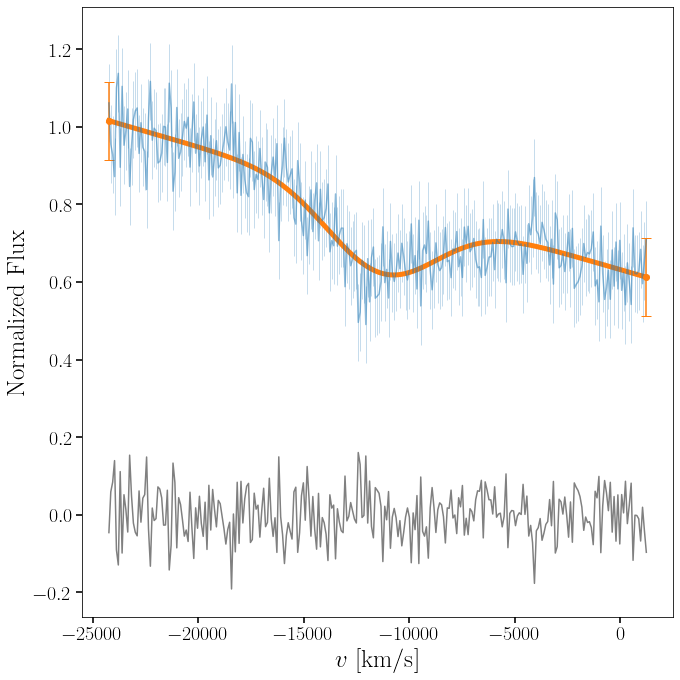

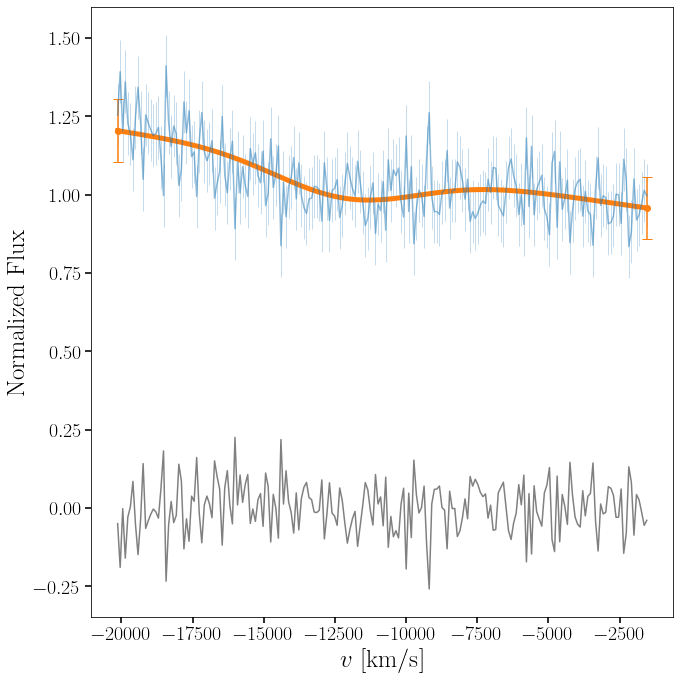

-93.0
LS estimation:
Velocity 1: -11210 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11167.297  364.896 -11542.811 -10840.120      7.021    4.965   
v_sig[0]    2582.113  453.414   2064.290   2912.734     10.673    8.237   
A[0]        -516.575   89.621   -587.724   -417.955      2.166    1.666   
sigma_0        0.007    0.005      0.000      0.008      0.000    0.000   
EW_0          25.067    4.125     20.799     28.655      0.098    0.075   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2772.268  2572.811  1.000  
v_sig[0]   2110.228  2417.331  1.000  
A[0]       1975.241  2207.585  1.001  
sigma_0    2109.367  1047.156  1.003  
EW_0       1986.698  2251.569  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11285.463  531.397 -11778.513 -10732.357      9.582    6.818   
v_sig[0]    2308.217  290.368   2126.686   2784.485      5.450    3.854   
A[0]         -39.859   33.966    -47.573     -0.012      0.719    0.615   
sigma_0        0.011    0.008      0.000      0.014      0.000    0.000   
EW_0           1.384    1.173      0.001      1.658      0.025    0.021   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3099.900  1896.311  1.002  
v_sig[0]   2560.467  2000.333  1.001  
A[0]       1952.596  1413.617  1.004  
sigma_0    1706.163   911.971  1.000  
EW_0       1967.321  1411.211  1.004  


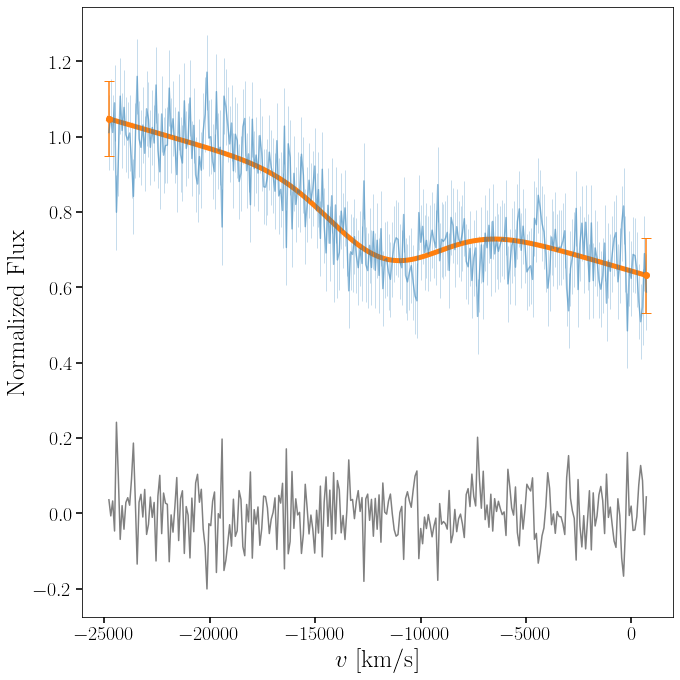

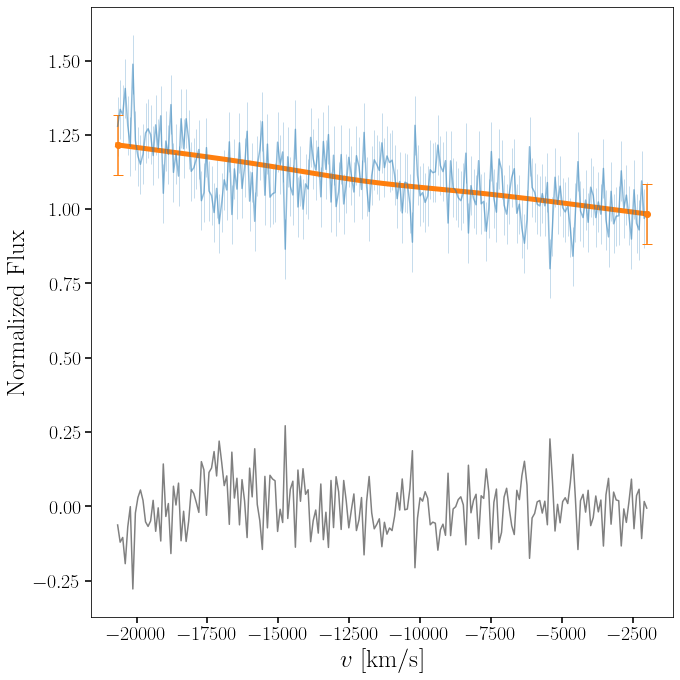

13.0
LS estimation:
Velocity 1: -11227 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11446.938  245.798 -11676.229 -11197.612      4.285    3.030   
v_sig[0]    2897.005  291.009   2575.598   3147.971      6.280    4.441   
A[0]        -917.788   99.035  -1012.204   -820.715      2.178    1.541   
sigma_0        0.007    0.005      0.000      0.009      0.000    0.000   
EW_0          41.265    4.105     36.954     44.922      0.089    0.063   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3292.613  2575.064    1.0  
v_sig[0]   2149.385  2642.553    1.0  
A[0]       2069.623  2384.382    1.0  
sigma_0    2234.936  1570.285    1.0  
EW_0       2112.539  2395.260    1.0  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10714.566  246.740 -10966.691 -10478.752      4.528    3.202   
v_sig[0]    2469.981  272.917   2110.638   2651.465      6.176    4.387   
A[0]        -630.376   89.408   -703.996   -532.551      2.154    1.523   
sigma_0        0.011    0.008      0.000      0.013      0.000    0.000   
EW_0          20.205    2.702     17.220     22.412      0.065    0.046   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2983.718  2692.929  1.000  
v_sig[0]   1845.518  1904.207  1.001  
A[0]       1729.394  2278.759  1.003  
sigma_0    2307.525  1588.008  1.001  
EW_0       1725.834  2377.088  1.002  


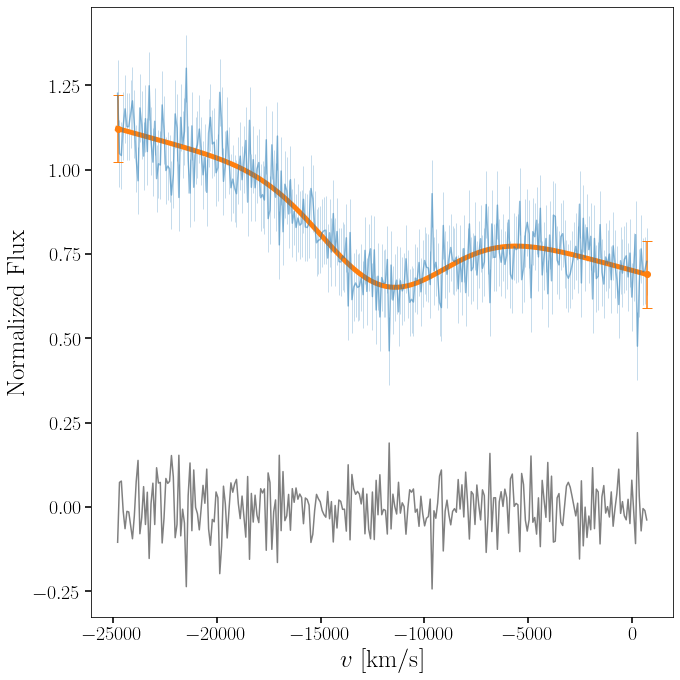

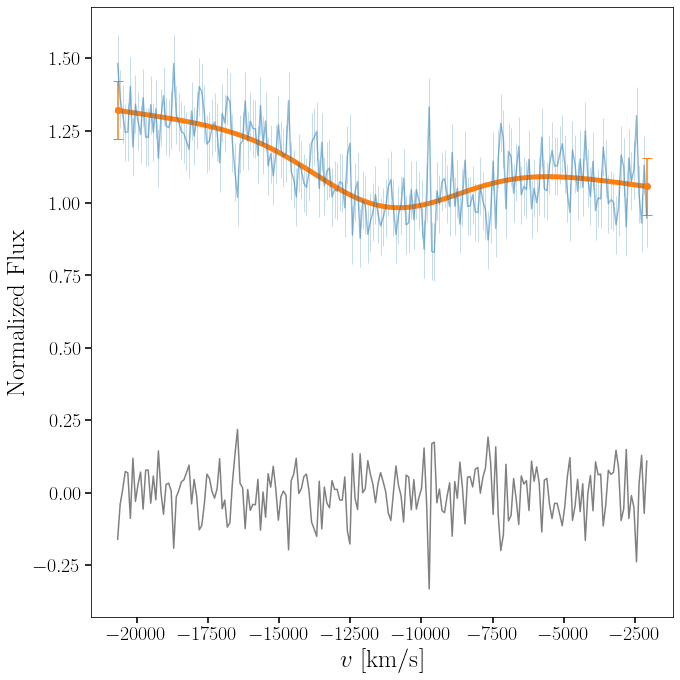

40.0
LS estimation:
Velocity 1: -11132 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11220.893  207.358 -11406.351 -10986.127      3.834    2.714   
v_sig[0]    2852.142  246.503   2580.918   3061.444      5.271    3.728   
A[0]       -1012.553   93.586  -1098.371   -917.736      2.087    1.476   
sigma_0        0.008    0.006      0.000      0.010      0.000    0.000   
EW_0          43.022    3.653     39.383     46.487      0.081    0.057   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2923.235  2683.097  1.002  
v_sig[0]   2189.378  2513.712  1.001  
A[0]       2004.284  2393.010  1.002  
sigma_0    1939.004  1077.925  1.000  
EW_0       2027.086  2579.512  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6971, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11592.146  232.064 -11808.298 -11347.081      5.076    3.594   
v_sig[0]    2206.558  172.058   2009.389   2246.163      4.074    2.918   
A[0]        -580.829   66.380   -643.510   -516.480      1.625    1.168   
sigma_0        0.024    0.014      0.005      0.035      0.000    0.000   
EW_0          17.761    1.931     15.670     19.348      0.047    0.034   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2085.329  2243.868  1.000  
v_sig[0]   1739.731  1538.426  1.001  
A[0]       1721.459  1705.182  1.004  
sigma_0    1545.737  1058.326  1.006  
EW_0       1748.459  1773.221  1.004  


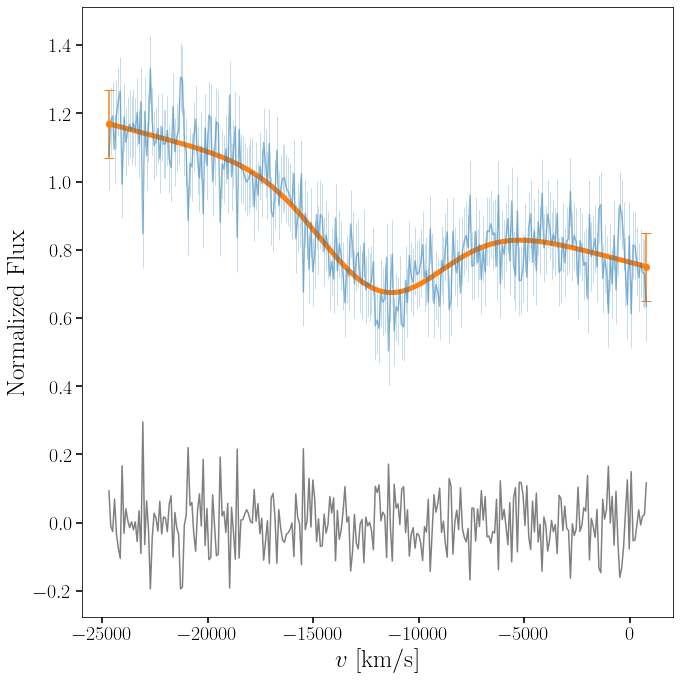

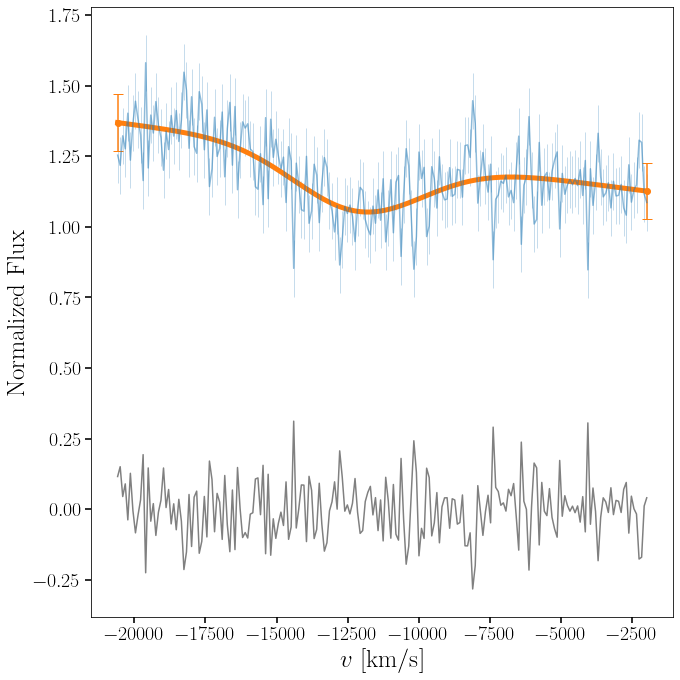

67.0
LS estimation:
Velocity 1: -12219 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12305.279  184.963 -12493.599 -12133.786      3.918    2.772   
v_sig[0]    2941.018  202.757   2744.576   3136.934      5.056    3.576   
A[0]       -1248.397   96.204  -1347.974  -1159.764      2.548    1.804   
sigma_0        0.019    0.012      0.001      0.026      0.000    0.000   
EW_0          43.164    3.062     40.163     46.119      0.080    0.057   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2230.605  2098.604  1.003  
v_sig[0]   1610.423  2182.915  1.002  
A[0]       1437.495  1989.215  1.001  
sigma_0    1447.156  1420.025  1.003  
EW_0       1465.629  2040.853  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12051.556  323.996 -12369.987 -11739.647      5.056    3.576   
v_sig[0]    2473.801  291.582   2074.844   2593.714      5.410    3.868   
A[0]        -519.108   96.476   -585.545   -399.365      1.825    1.319   
sigma_0        0.080    0.010      0.071      0.091      0.000    0.000   
EW_0          13.204    2.365     10.357     14.940      0.045    0.032   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4115.342  3128.628  1.001  
v_sig[0]   2993.833  2499.530  1.000  
A[0]       2849.605  2525.330  1.002  
sigma_0    4165.889  2268.381  1.000  
EW_0       2869.103  2560.130  1.001  


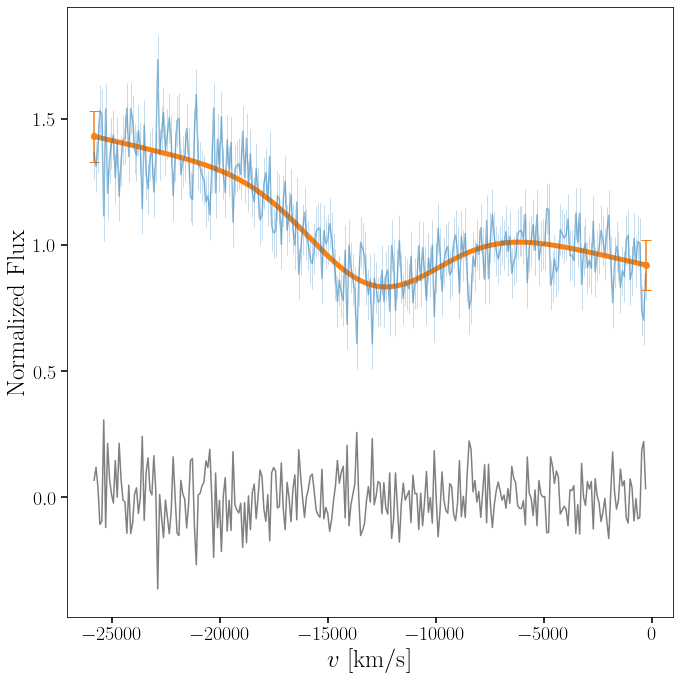

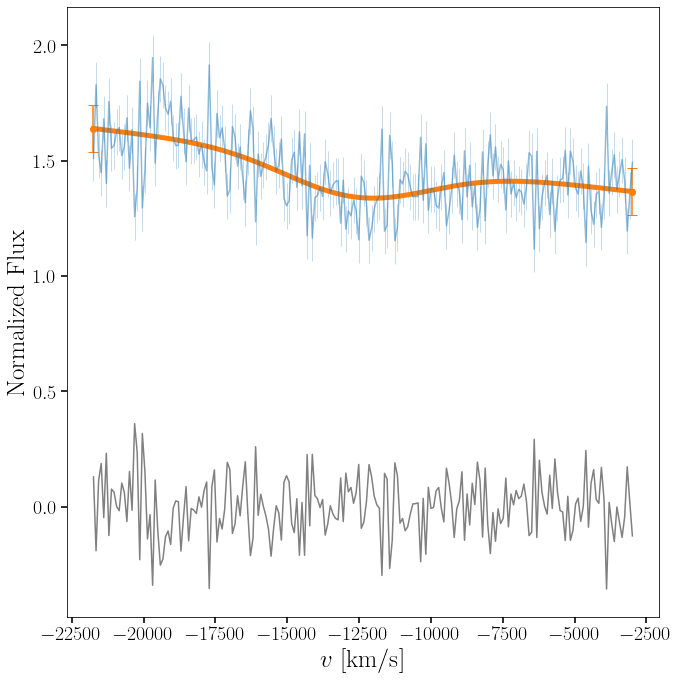

93.0
LS estimation:
Velocity 1: -13184 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12961.166  358.580 -13315.748 -12603.254      5.364    3.796   
v_sig[0]    3085.233  359.090   2583.834   3235.118      6.816    4.863   
A[0]        -818.000  161.808   -955.892   -647.610      3.351    2.460   
sigma_0        0.126    0.010      0.116      0.136      0.000    0.000   
EW_0          16.478    3.109     13.156     19.134      0.064    0.047   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4477.209  3042.341  1.000  
v_sig[0]   2713.619  2600.182  1.001  
A[0]       2484.642  2205.059  1.001  
sigma_0    4877.949  2886.670  1.000  
EW_0       2492.876  2048.906  1.001  


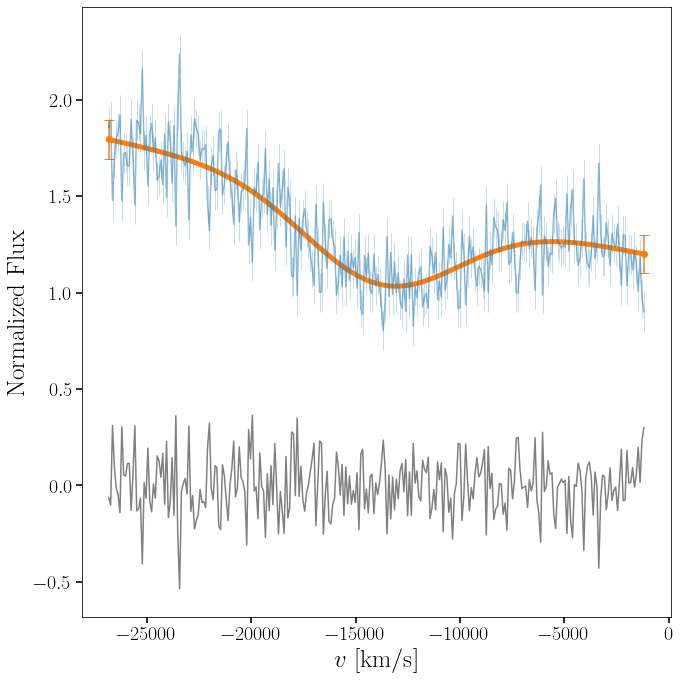

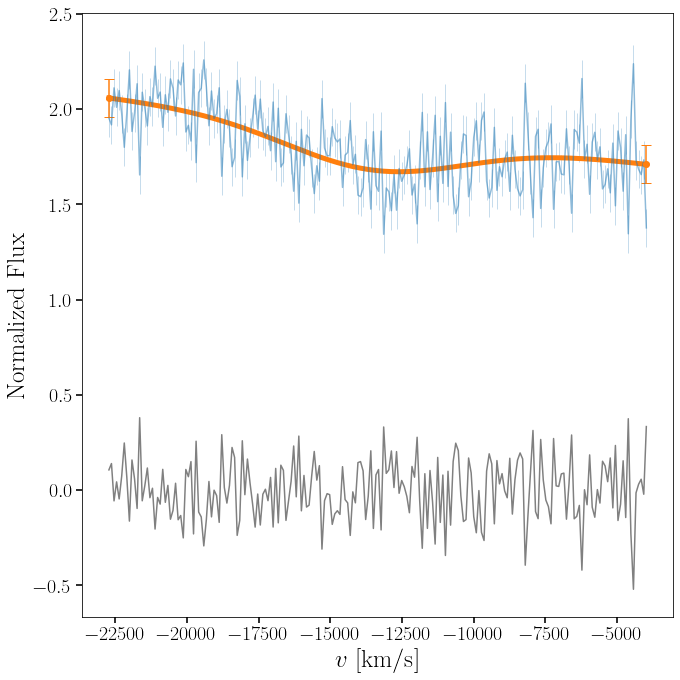

-13.0
LS estimation:
Velocity 1: -11001 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13021.936  244.663 -13277.267 -12796.097      4.007    2.835   
v_sig[0]    2083.694  157.227   1916.945   2113.559      2.801    1.986   
A[0]        -431.661   56.320   -489.806   -380.438      1.086    0.768   
sigma_0        0.008    0.006      0.000      0.010      0.000    0.000   
EW_0          16.790    2.096     14.841     18.938      0.040    0.029   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3724.572  3093.579  1.002  
v_sig[0]   2563.416  1684.140  1.000  
A[0]       2684.011  2630.860  1.001  
sigma_0    2388.126  1685.781  1.001  
EW_0       2704.749  2732.195  1.000  


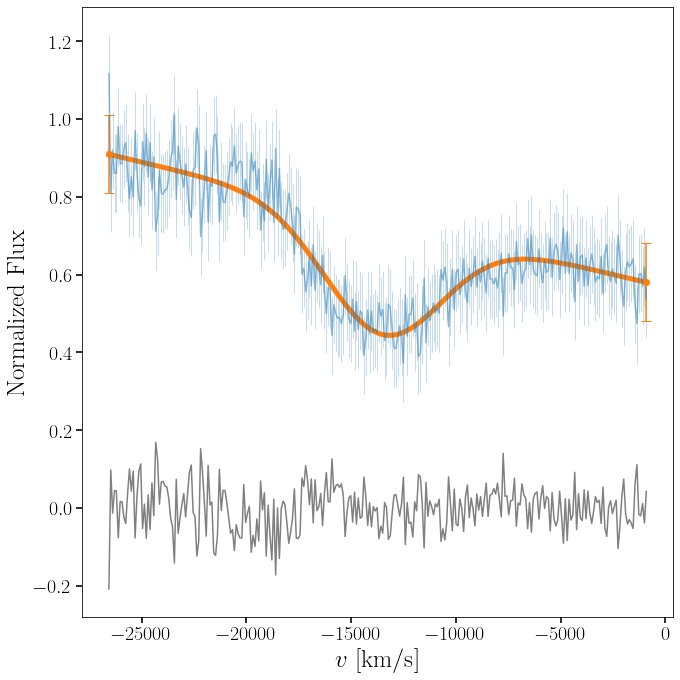

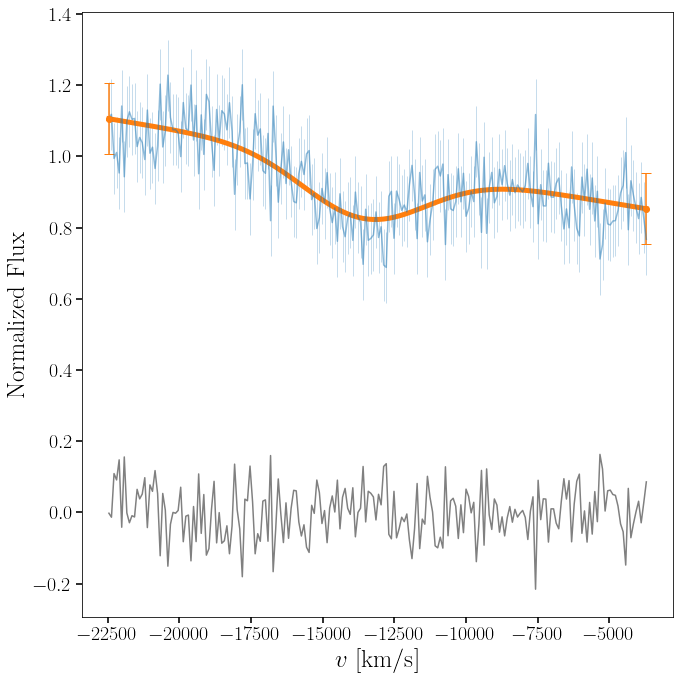

-40.0
LS estimation:
Velocity 1: -11950 km/s


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:91: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6364, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5885, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -18268.469  533.898 -18830.270 -17778.300     12.871    9.103   
v_sig[0]    3093.850  383.023   2449.361   3328.203      7.745    5.510   
A[0]        -332.318  128.107   -442.127   -190.225      3.505    2.520   
sigma_0        0.105    0.010      0.095      0.115      0.000    0.000   
EW_0           6.915    2.620      4.050      9.207      0.071    0.051   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1710.195  1764.439  1.002  
v_sig[0]   2353.958  1889.637  1.001  
A[0]       1332.829  1428.608  1.003  
sigma_0    2550.657  1889.201  1.004  
EW_0       1346.537  1450.178  1.003  


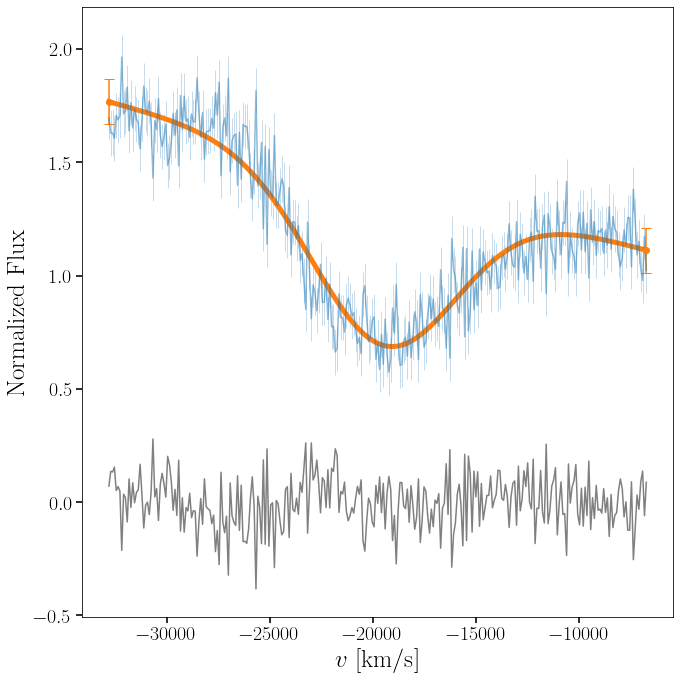

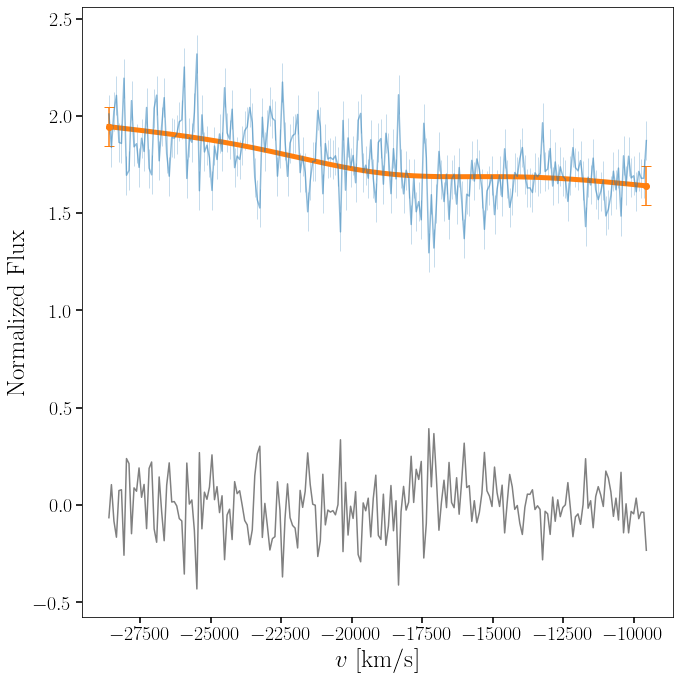

In [209]:
syn_mc = np.empty_like(synth_spec, dtype=float)
syn_rho = np.empty_like(synth_spec, dtype=float)
syn_mu = np.empty_like(synth_spec, dtype=float)
v_Si_Shen = np.empty_like(synth_spec, dtype=float)
v_Si_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_err_Shen = np.empty_like(synth_spec, dtype=float)

for k in range(len(synth_spec)):
    syn_mc[k] = float(synth_spec[k].split('_')[2])
    syn_rho[k] = float(synth_spec[k].split('_')[4])
    syn_mu[k] = float(synth_spec[k].split('_')[6])
    print(syn_mu[k])
    Spec = SpectrumSN_Lines(synth_spec[k], z, snr=30)
    Spec.add_line("SiII0", 5750, 6450, lines=[6371.359, 6347.103])
    Spec.line["SiII0"].LS_estimator()
    v_temp = Spec.line["SiII0"].theta_LS[2]

    Spec.add_line(
        "SiII_6355",
        lambda_rf(6347.103, v_temp) - 250,
        lambda_rf(6371.359, v_temp) + 250,
        lines=[6371.359, 6347.103],
    )
    Spec.line["SiII_6355"].MCMC_sampler(
        vel_mean_mu=[-1e4],
        vel_mean_sig=[3e3],
        initial=Spec.line["SiII0"].theta_LS,
        vel_var_lim=[1e4, 1e9],
        A_lim=[-1e6, 0],
    )
    v_Si_Shen[k] = Spec.line["SiII_6355"].theta_MCMC[2]

    Spec.add_line(
        "SiII_5972",
        lambda_rf(5957.561, v_temp) - 160,
        lambda_rf(5978.929, v_temp) + 180,
        lines=[5957.561, 5978.929],
    )
    vel_var_6355 = np.exp(Spec.line["SiII_6355"].theta_MCMC[3])
    Spec.line["SiII_5972"].MCMC_sampler(
        vel_mean_mu=[v_Si_Shen[k]],
        vel_mean_sig=[5e2],
        initial=Spec.line["SiII_6355"].theta_MCMC,
        vel_var_lim=[vel_var_6355 / 2, vel_var_6355 * 1.2],
        A_lim=[-1e6, 0],
    )

    EW_Si_6355_Shen[k], EW_Si_5972_Shen[k] = (
        Spec.line["SiII_6355"].EW[0],
        Spec.line["SiII_5972"].EW[0],
    )
    EW_Si_6355_err_Shen[k], EW_Si_5972_err_Shen[k] = (
        Spec.line["SiII_6355"].sig_EW[0],
        Spec.line["SiII_5972"].sig_EW[0],
    )
    # if (
    #     np.abs(
    #         Spec.line["SiII_5972"].theta_MCMC[2] - Spec.line["SiII_6355"].theta_MCMC[2]
    #     )
    #     > 2000
    # ):
    #     EW_Si_5972_Shen[k] = np.nan
    # if np.abs(syn_mu[k]) >= 90:
    #     EW_Si_6355_Shen[k], EW_Si_5972_Shen[k], v_Si_Shen[k] = np.nan, np.nan, np.nan
    plt.show()

In [210]:
M_B_max_Shen = np.empty_like(synth_lc, dtype=float)

for k in range(len(synth_lc)):
    lc = np.loadtxt(synth_lc[k])
    M_B = lc[:, -1]
    M_B_max_Shen[k] = M_B.min()

In [211]:
np.savetxt(
    fname="./Shen+21_model/1.1Msun_spec_para.dat",
    X=np.array(
        [
            syn_mc,
            syn_mu / 100,
            syn_rho,
            M_B_max_Shen,
            v_Si_Shen,
            v_Si_err_Shen,
            EW_Si_5972_Shen,
            EW_Si_5972_err_Shen,
            EW_Si_6355_Shen,
            EW_Si_6355_err_Shen,
        ]
    ).T,
    fmt="%.1f %.2f %.0f %.3f %.3f %.3f %.3f %.3f %.3f %.3f",
    header="m mu density M_B_max v_Si v_Si_err EW_Si_5972 EW_Si_5972_err EW_Si_6355 EW_Si_6355_err",
)

## Model comparison plot

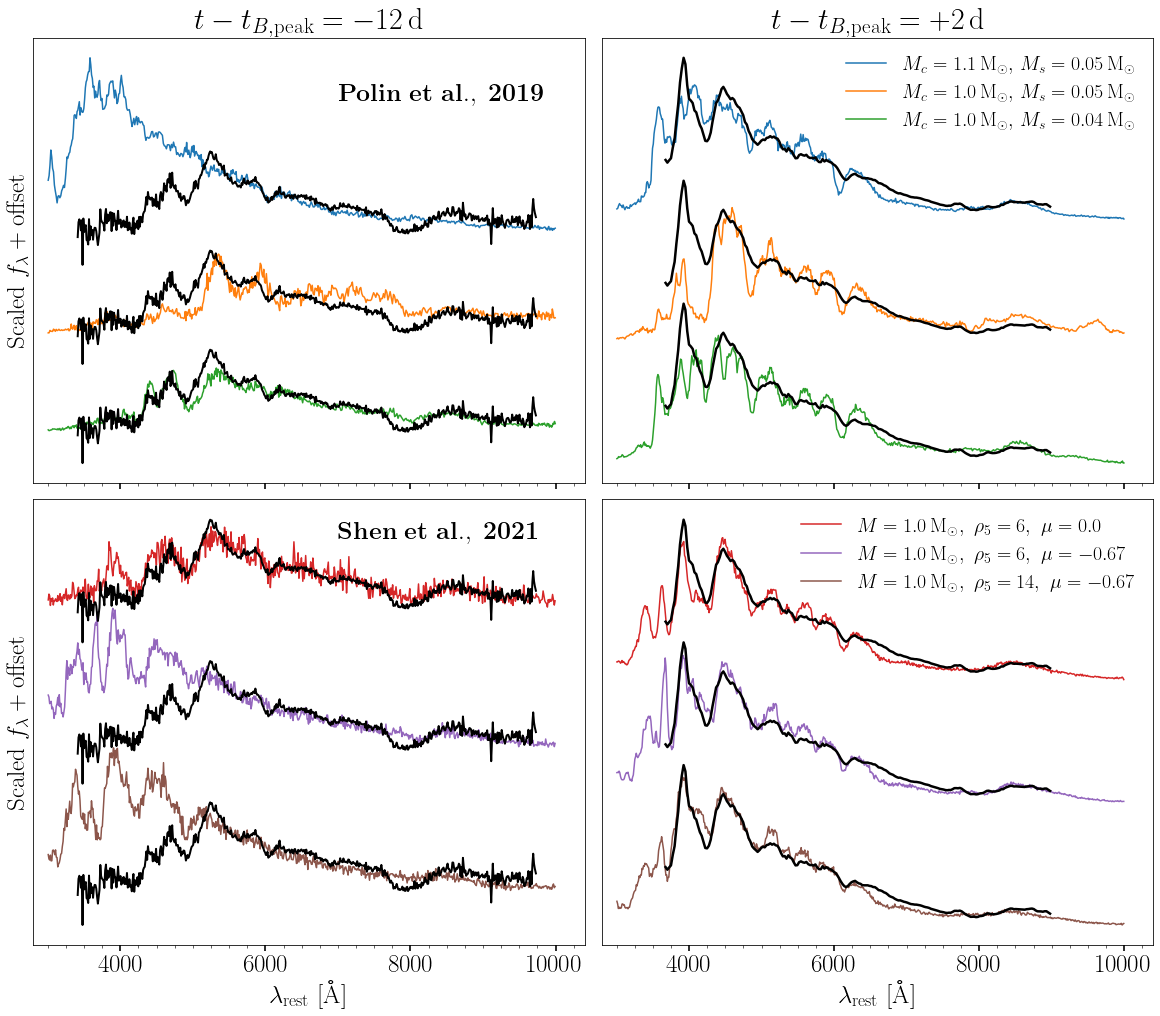

In [41]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, constrained_layout=True)

h0 = [2.9, 2.2]

# Polin+2019 models
ax = axes[0]
models_Polin = sorted(glob.glob("./Polin+19_model/*1*phase*spec*"), reverse=True)
k = -1
for model in models_Polin:
    mc = float(model.split("_")[2])
    ms = float(model.split("_")[4])
    if (ms >= 0.06) or (ms <= 0.03) or (mc > 1.1):
        continue
    phase = float(model.split("_")[-2])
    if phase == -11:
        a = ax[0]
        h = h0[1]
    elif phase == 2:
        a = ax[1]
        k += 1
        h = h0[1]
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M_c = {mc}\,"
        + r"\mathrm{M_\odot},\,"
        + f"M_s = {ms}\,"
        + r"\mathrm{M_\odot}$",
        color=colors[k],
    )

# Shen+2021 models
ax = axes[1]
models_Shen = sorted(
    glob.glob("./Shen+21_model/*-67*phase*spec*")
    + glob.glob("./Shen+21_model/*6e5*_0_*phase*spec*"),
    reverse=True,
)

k = -1
for model in models_Shen:
    mc = float(model.split("_")[2])
    dens = int(float(model.split("_")[4]) / 1e5)
    phase = float(model.split("_")[-2])
    mu = float(model.split("_")[-4])
    if mc > 1:
        continue
    if phase == -11:
        a = ax[0]
        h = h0[0]
    elif phase == 2:
        a = ax[1]
        h = h0[1]
        k += 1
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M = {mc}\,"
        + r"\mathrm{M_\odot},\ "
        + rf"\rho_5 = {dens},\ \mu = {mu/100}$",
        zorder=int(dens),
        lw=1.5,
        color=colors[k + 3],
    )
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")

axes[0, 1].legend(prop={"size": 20}, frameon=False)
axes[1, 1].legend(prop={"size": 20}, frameon=False)

for i, (a, l) in enumerate(zip(axes[:, 0], [3, 3])):
    spec1_bin = data_binning(spec1, size=10)
    for k in range(l):
        a.plot(
            spec1_bin[:, 0] / (1 + z),
            spec1_bin[:, 1]
            / np.median(spec1[(spec1[:, 0] > 5800) & (spec1[:, 0] < 6500), 1])
            - k * h0[-1 - i],
            color="k",
            zorder=100,
            lw=2,
        )
    a.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
for a, l in zip(axes[:, 1], [3, 3]):
    for k in range(l):
        a.plot(
            spec2[:, 0] / (1 + z),
            spec2[:, 1]
            / np.median(spec2[(spec2[:, 0] > 5800) & (spec2[:, 0] < 6500), 1])
            - k * h0[1],
            color="k",
            zorder=100,
            lw=2.5,
        )

# axes[0, 0].set_ylim(-0.3, 3.5)
# axes[0, 1].set_ylim(-0.1, 3)

for a in axes.ravel():
    a.set_yticks([])
    a.xaxis.set_minor_locator(MultipleLocator(250))

axes[0, 0].set_xlim(2800, 10400)

axes[0, 0].set_title(r"$t - t_{B,\mathrm{peak}} = -12\,\mathrm{d}$", pad=10)
axes[0, 1].set_title(r"$t - t_{B,\mathrm{peak}} = +2\,\mathrm{d}$", pad=10)
axes[0, 0].text(7000, 3, r"$\mathbf{Polin\ et\ al.,\ 2019}$")
axes[1, 0].text(7000, 1.5, r"$\mathbf{Shen\ et\ al.,\ 2021}$")

plt.savefig("../paper/figures/model_comparison_spec.pdf", bbox_inches="tight")